<h2>Business Problem </h2>
<h3>Description</h3>

<h3>Customer Relationship Management (CRM)

</h3> is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling).

The most practical way, in a CRM system, to build knowledge on customer is to produce scores. A score (the output of a model) is an evaluation for all instances of a target variable to explain (i.e. churn, appetency or up-selling). Tools which produce scores allow to project, on a given population, quantifiable information. The score is computed using input variables which describe instances. Scores are then used by the information system (IS), for example, to personalize the customer relationship. An industrial customer analysis platform able to build prediction models with a very large number of input variables has been developed by Orange Labs. This platform implements several processing methods for instances and variables selection, prediction and indexation based on an efficient model combined with variable selection regularization and model averaging method. The main characteristic of this platform is its ability to scale on very large datasets with hundreds of thousands of instances and thousands of variables. The rapid and robust detection of the variables that have most contributed to the output prediction can be a key factor in a marketing application.

The challenge is to beat the in-house system developed by Orange Labs. It is an opportunity to prove that you can deal with a very large database, including heterogeneous noisy data (numerical and categorical variables), and unbalanced class distributions. Time efficiency is often a crucial point. Therefore part of the competition will be time-constrained to test the ability of the participants to deliver solutions quickly.

## Taking reference from some blogs and research papers
1. http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf
2. https://www.kdd.org/exploration_files/v11-2-12-KDDCUP09_analysis.pdf
3. https://medium.com/@kushaldps1996/customer-relationship-prediction-kdd-cup-2009-6b57d08ffb0

## Metrics used for evaluation

1. Average ROC_AUC score of appetency, churning and upselling.
2. Other Metric which can be useful is F1_Score

In [1]:
%%time
from datetime import datetime
from tqdm import tqdm_gui
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly as pt
import plotly.offline as pf
pf.init_notebook_mode()
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import dask.dataframe as dd
# from IPython.core.interactiveshell import InteractiveShell  
# InteractiveShell.ast_node_interactivity = "all"

Wall time: 22.5 s


### Reading the orange_small_train data 

In [2]:
train_data = pd.read_csv(r"C:\Users\patha\Documents\kdd cup 2009\orange_small_train.data",sep='\t') # reading the orange_small_data into train data
print("orange small train datasets contain {} rows and {} columns".format(train_data.shape[0],train_data.shape[1]))
train_data.head(10)

orange small train datasets contain 50000 rows and 230 columns


Var1  Var2  Var3  Var4  Var5    Var6  Var7  Var8  Var9  Var10  ...  \
0   NaN   NaN   NaN   NaN   NaN  1526.0   7.0   NaN   NaN    NaN  ...   
1   NaN   NaN   NaN   NaN   NaN   525.0   0.0   NaN   NaN    NaN  ...   
2   NaN   NaN   NaN   NaN   NaN  5236.0   7.0   NaN   NaN    NaN  ...   
3   NaN   NaN   NaN   NaN   NaN     NaN   0.0   NaN   NaN    NaN  ...   
4   NaN   NaN   NaN   NaN   NaN  1029.0   7.0   NaN   NaN    NaN  ...   
5   NaN   NaN   NaN   NaN   NaN   658.0   7.0   NaN   NaN    NaN  ...   
6   NaN   NaN   NaN   NaN   NaN  1680.0   7.0   NaN   NaN    NaN  ...   
7   NaN   NaN   NaN   NaN   NaN    77.0   0.0   NaN   NaN    NaN  ...   
8   NaN   NaN   NaN   NaN   NaN  1176.0   7.0   NaN   NaN    NaN  ...   
9   NaN   NaN   NaN   NaN   NaN  1141.0   7.0   NaN   NaN    NaN  ...   

    Var221   Var222      Var223  Var224  Var225  Var226   Var227  \
0     oslk  fXVEsaq  jySVZNlOJy     NaN     NaN    xb3V     RAYp   
1     oslk  2Kb5FSF  LM8l689qOp     NaN     NaN    fKCe     RAYp   
2  Al6ZaUT  NKv4yOc  jySVZNlOJy     NaN    kG3k    Qu4f  02N6s8f   
3     oslk  CE7uk3u  LM8l689qOp     NaN     NaN    FSa2     RAYp   
4     oslk  1J2cvxe  LM8l689qOp     NaN    kG3k    FSa2     RAYp   
5     zCkv  QqVuch3  LM8l689qOp     NaN     NaN    Qcbd  02N6s8f   
6     oslk  XlgxB9z  LM8l689qOp     NaN    kG3k    FSa2     RAYp   
7     oslk  R2LdzOv         NaN     NaN     NaN    FSa2     RAYp   
8     zCkv  K2SqEo9  jySVZNlOJy     NaN    kG3k    PM2D     6fzt   
9     oslk  EPqQcw6  LM8l689qOp     NaN    kG3k    FSa2     RAYp   

                   Var228  Var229  Var230  
0           F2FyR07IdsN7I     NaN     NaN  
1           F2FyR07IdsN7I     NaN     NaN  
2           ib5G6X1eUxUn6    am7c     NaN  
3           F2FyR07IdsN7I     NaN     NaN  
4           F2FyR07IdsN7I    mj86     NaN  
5                 Zy3gnGM    am7c     NaN  
6                 55YFVY9    am7c     NaN  
7           F2FyR07IdsN7I     NaN     NaN  
8  am14IcfM7tWLrUmRT52KtA    am7c     NaN  
9                 55YFVY9     NaN     NaN  

[10 rows x 230 columns]

#### From the above data.head() function we can see that this data contains numerous NaN values for both categorical and numerical variable , but we will find a way out from this problem.

#### Lets Calculate how many NaN values each features or columns contains

In [3]:
# in this we are calculating number of nan values each feature in our data contains
start = datetime.now()
columns = list(train_data.columns)
count=0
na_val = {}
for col in columns:
    if True in train_data[col].isna().value_counts():
        na_val[col] = train_data[col].isna().value_counts()[True]
    else:
        na_val[col] = 0
print("Total time taken for this snippet is {}".format(datetime.now()-start))
# this above feature is calculating number of nan values present in each feature which will help in deleting those features which has above 70% of nan values in it.

Total time taken for this snippet is 0:00:00.679218


In [4]:
na_val_sorted = sorted(na_val.items(),key = lambda kv:kv[1])[::-1]

In [5]:
na_val_sorted = pd.DataFrame(np.array(na_val_sorted),columns=["Features","Total NA values"])
# print(na_val_sorted['Total NA values'].value_counts()[:10])
na_val_sorted.head()

Features Total NA values
0   Var230           50000
1   Var209           50000
2   Var185           50000
3   Var175           50000
4   Var169           50000

In [7]:
train_data['appetency'] = appetency[0]
train_data['churning'] = churn[0]
train_data['upselling'] = upsell[0]
train_data.head()

Var1  Var2  Var3  Var4  Var5    Var6  Var7  Var8  Var9  Var10  ...  Var224  \
0   NaN   NaN   NaN   NaN   NaN  1526.0   7.0   NaN   NaN    NaN  ...     NaN   
1   NaN   NaN   NaN   NaN   NaN   525.0   0.0   NaN   NaN    NaN  ...     NaN   
2   NaN   NaN   NaN   NaN   NaN  5236.0   7.0   NaN   NaN    NaN  ...     NaN   
3   NaN   NaN   NaN   NaN   NaN     NaN   0.0   NaN   NaN    NaN  ...     NaN   
4   NaN   NaN   NaN   NaN   NaN  1029.0   7.0   NaN   NaN    NaN  ...     NaN   

   Var225  Var226   Var227         Var228  Var229  Var230  appetency  \
0     NaN    xb3V     RAYp  F2FyR07IdsN7I     NaN     NaN         -1   
1     NaN    fKCe     RAYp  F2FyR07IdsN7I     NaN     NaN         -1   
2    kG3k    Qu4f  02N6s8f  ib5G6X1eUxUn6    am7c     NaN         -1   
3     NaN    FSa2     RAYp  F2FyR07IdsN7I     NaN     NaN         -1   
4    kG3k    FSa2     RAYp  F2FyR07IdsN7I    mj86     NaN         -1   

   churning  upselling  
0        -1         -1  
1         1         -1  
2        -1         -1  
3        -1         -1  
4        -1         -1  

[5 rows x 233 columns]

### EDA(Exploratory Data Analysis)

In [16]:
# below code snippet stores only those features which have no nan's and categorical variable is stored in cat_var list and
# numerical variable stored in num_var list.
col_nonan = []
for key in na_val.keys():
    if na_val[key]==0:# to check number of na_val assigned to each feature
        col_nonan.append(key)
    else:
        continue
col_nonan = col_nonan[:-3] # this is done because last 3 variable was appetency,churning and upselling.
print(col_nonan)
print("\n")
cat_var,num_var=[],[]
for col in col_nonan:
    if train_data[col].dtype=='O':
        cat_var.append(col)
    else:
        num_var.append(col)
print("Categorical Variable in this list is -> ",cat_var) # categorical features
print("\n")

print("Numerical Variable in this list is -> ",num_var) # numerical features

['Var57', 'Var73', 'Var113', 'Var193', 'Var195', 'Var196', 'Var198', 'Var204', 'Var207', 'Var210', 'Var211', 'Var212', 'Var216', 'Var220', 'Var221', 'Var222', 'Var226', 'Var227', 'Var228']


Categorical Variable in this list is ->  ['Var193', 'Var195', 'Var196', 'Var198', 'Var204', 'Var207', 'Var210', 'Var211', 'Var212', 'Var216', 'Var220', 'Var221', 'Var222', 'Var226', 'Var227', 'Var228']


Numerical Variable in this list is ->  ['Var57', 'Var73', 'Var113']


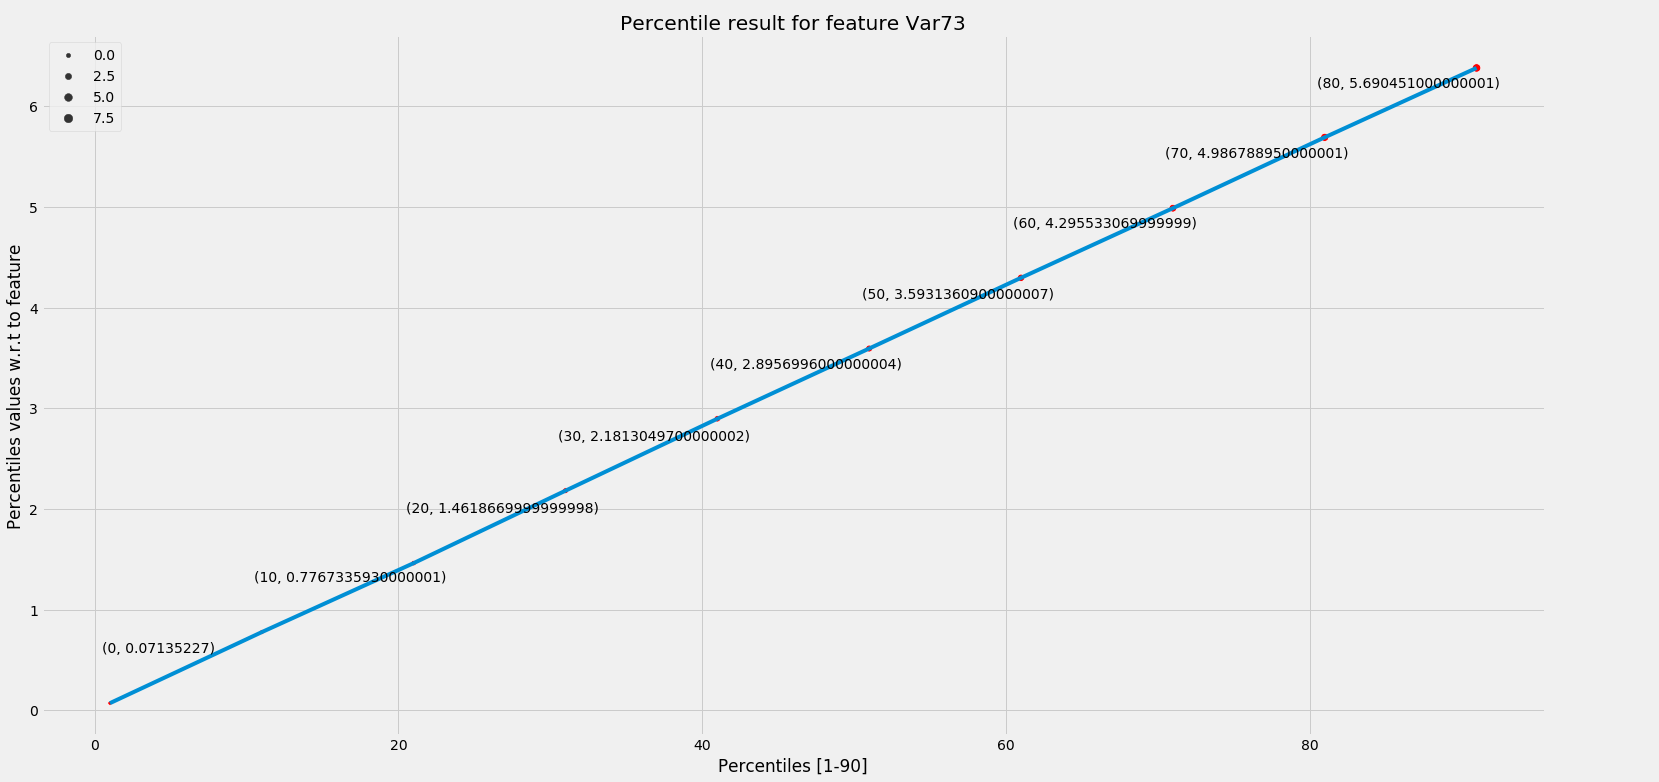

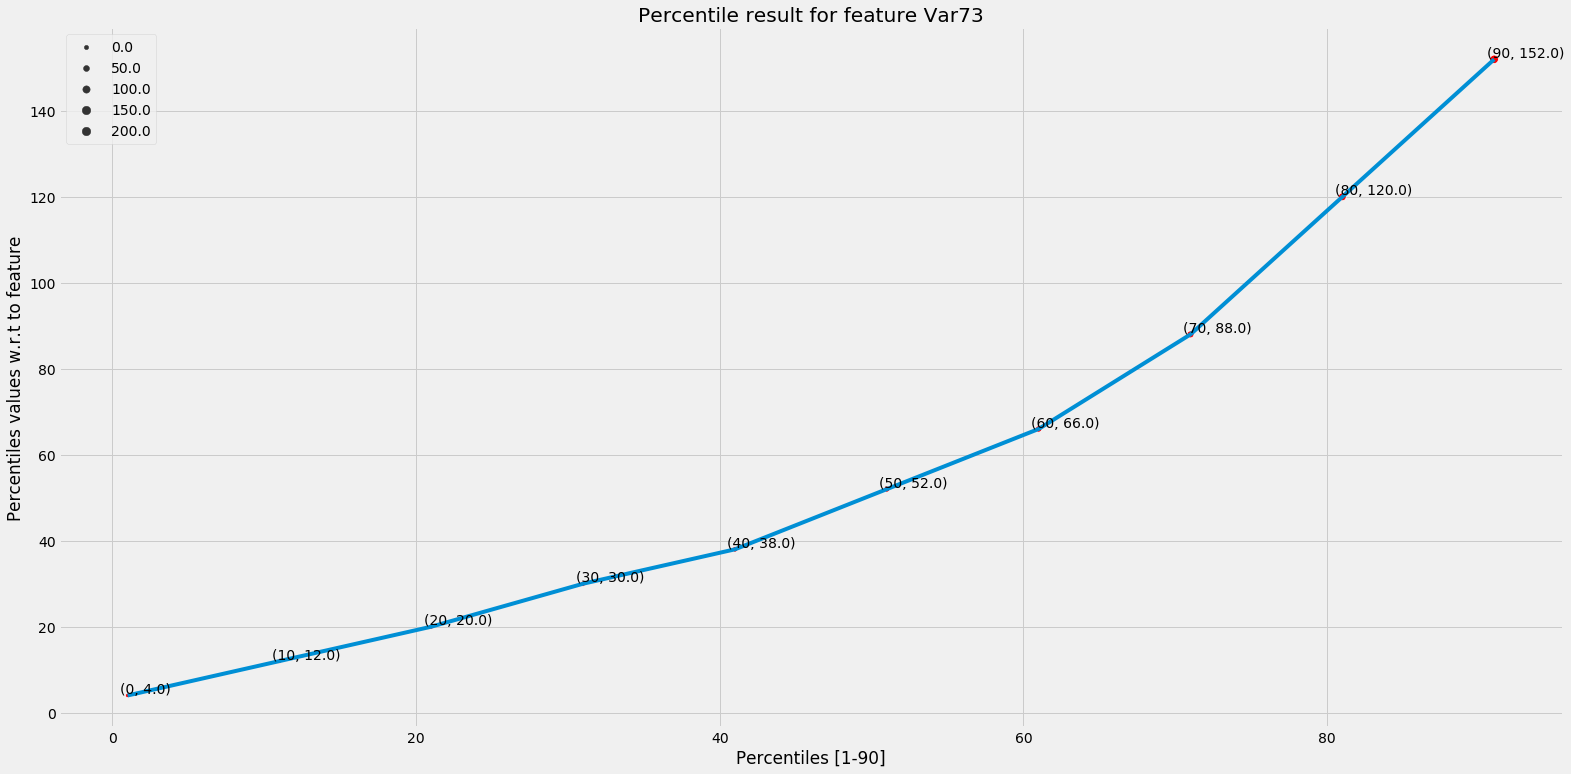

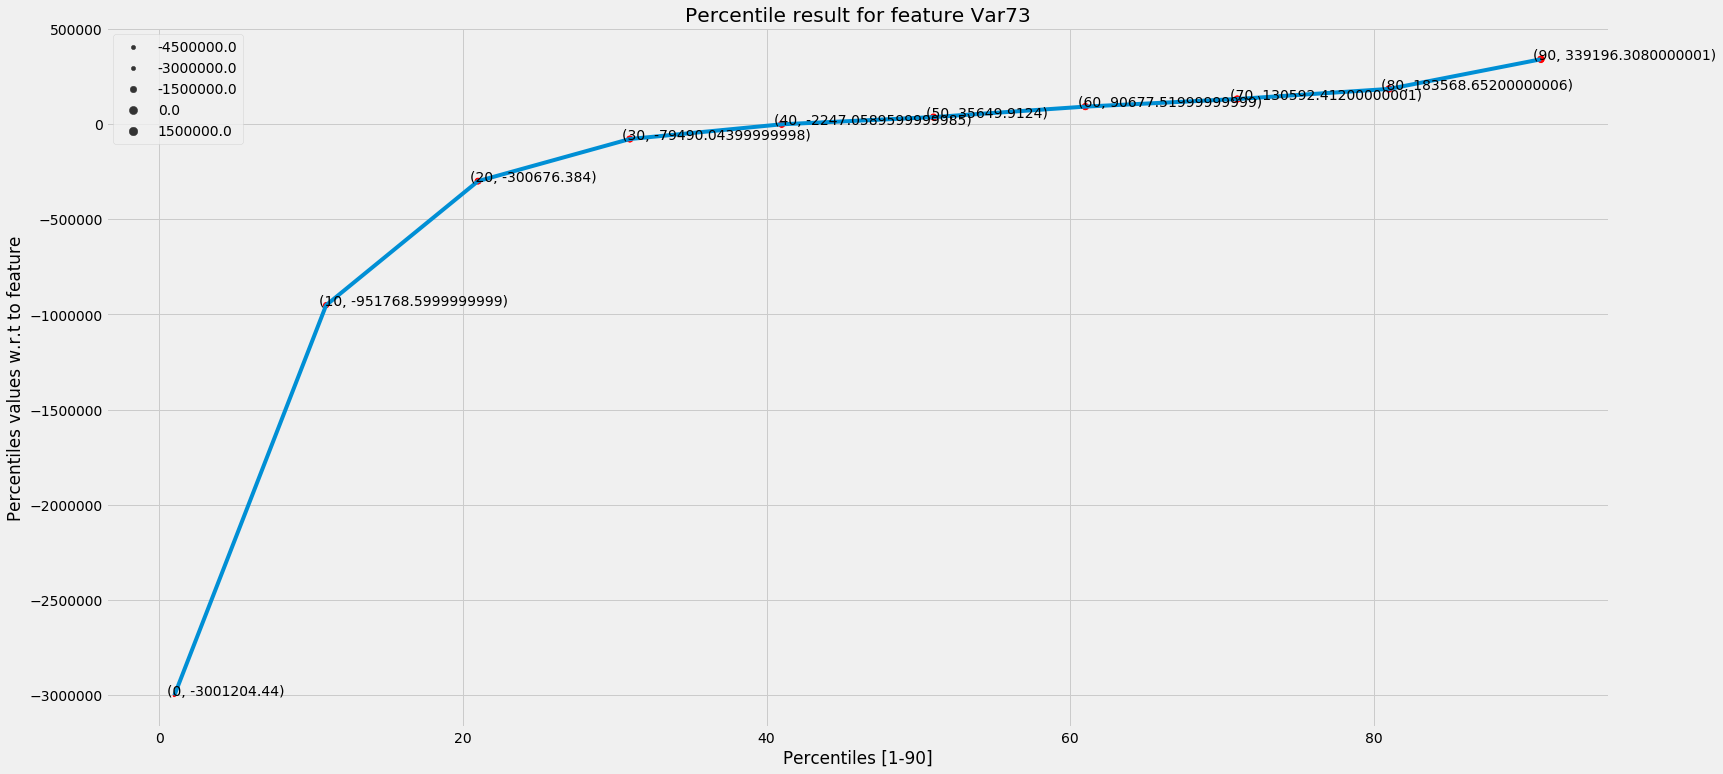

In [182]:
# below is the percentiles result distribution of numerical variable having no nan values.
# how may style avalaible can be seen using : plt.style.available function and you can use it by below function
# np.percentile give percentile value of a feature for more info https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html
# if you are using jupyter notebok you can see function info using ?np.percentile

plt.style.use("fivethirtyeight")
for col in num_var:
    percentile = []
    for i in range(1,100,10):
        percentile.append(np.percentile(train_data[col],i))
    fig, ax = plt.subplots(figsize = (24,12))
# goto this https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.annotate.html for more info about annotation.
    for i, txt in enumerate(percentile):
        ax.annotate((i*10,percentile[i]),xy = (i*10+0.5,percentile[i]+0.5))
    sns.scatterplot(x = np.arange(1,100,10),y = percentile,size =percentile,color = "red")
    sns.lineplot(x = np.arange(1,100,10),y = percentile)
    plt.xlabel("Percentiles [1-90]")
    plt.ylabel("Percentiles values w.r.t to feature")
    plt.title("Percentile result for feature Var73")
    plt.show()

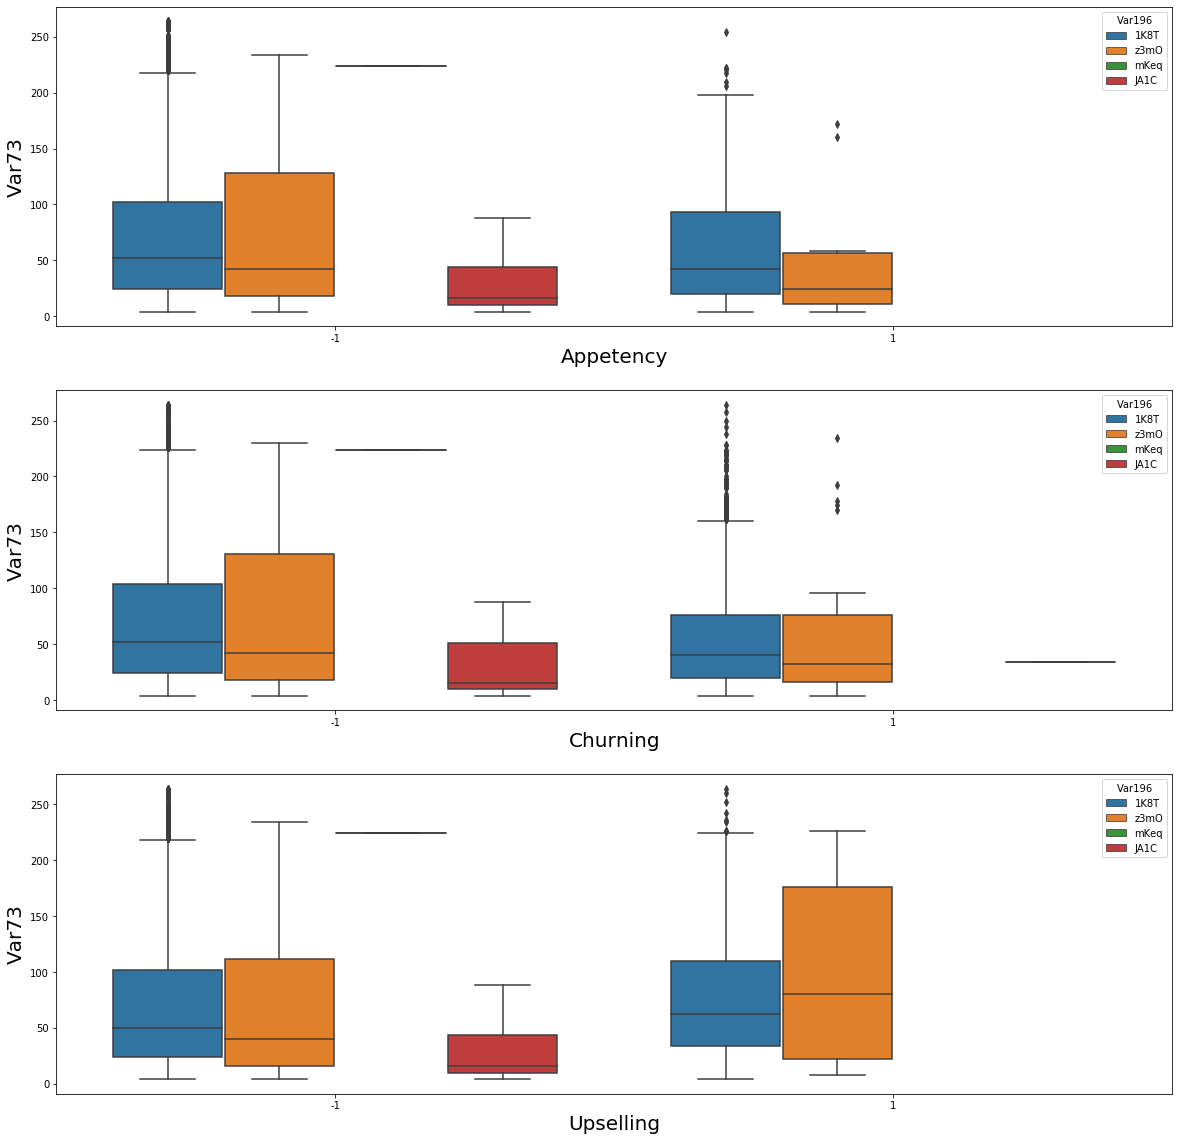

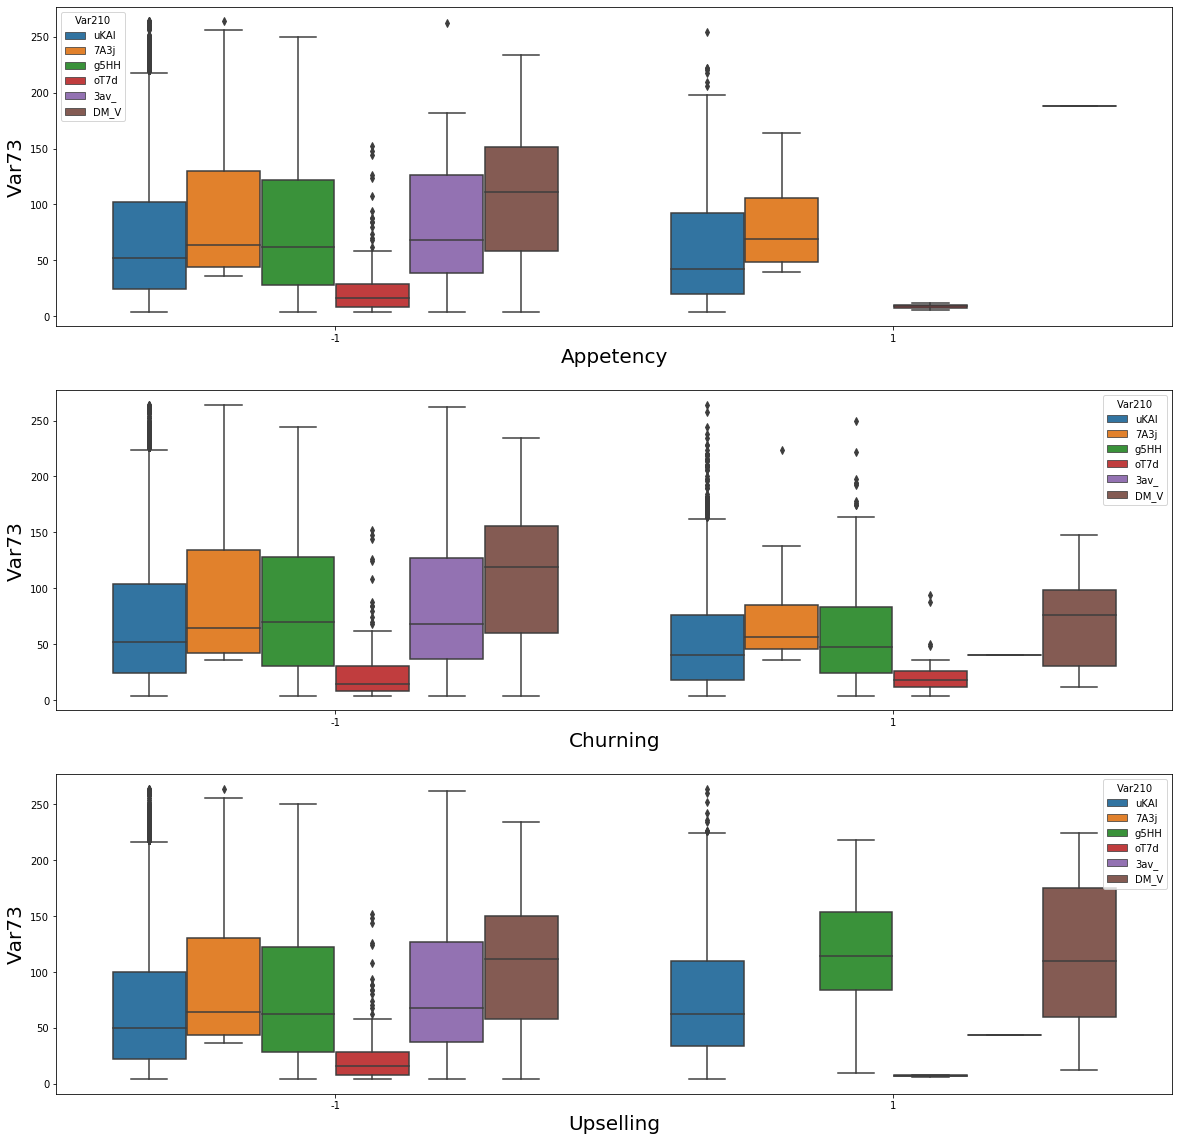

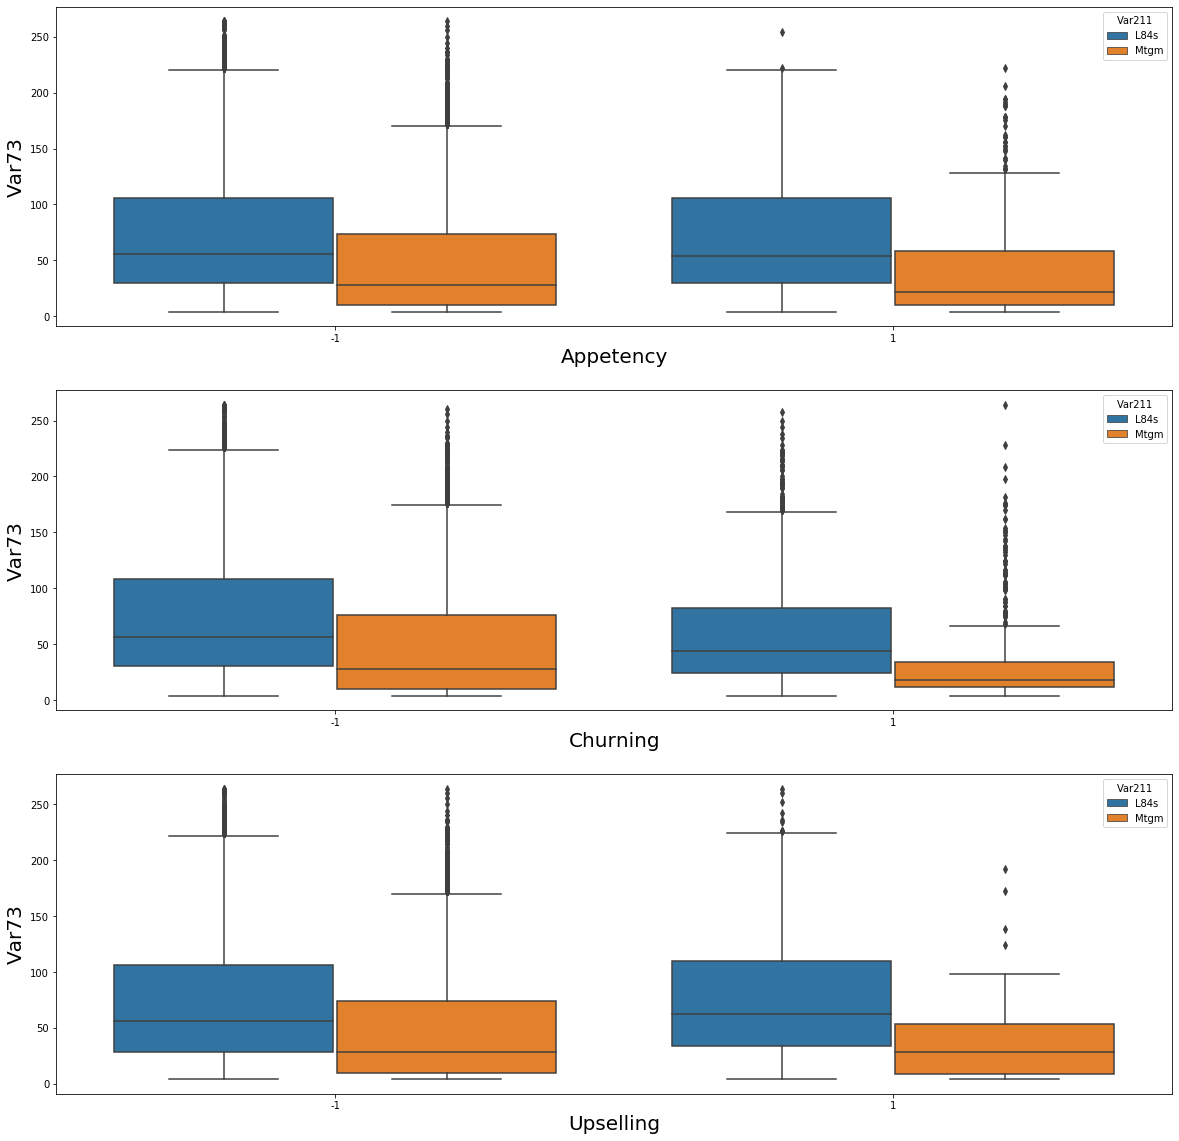

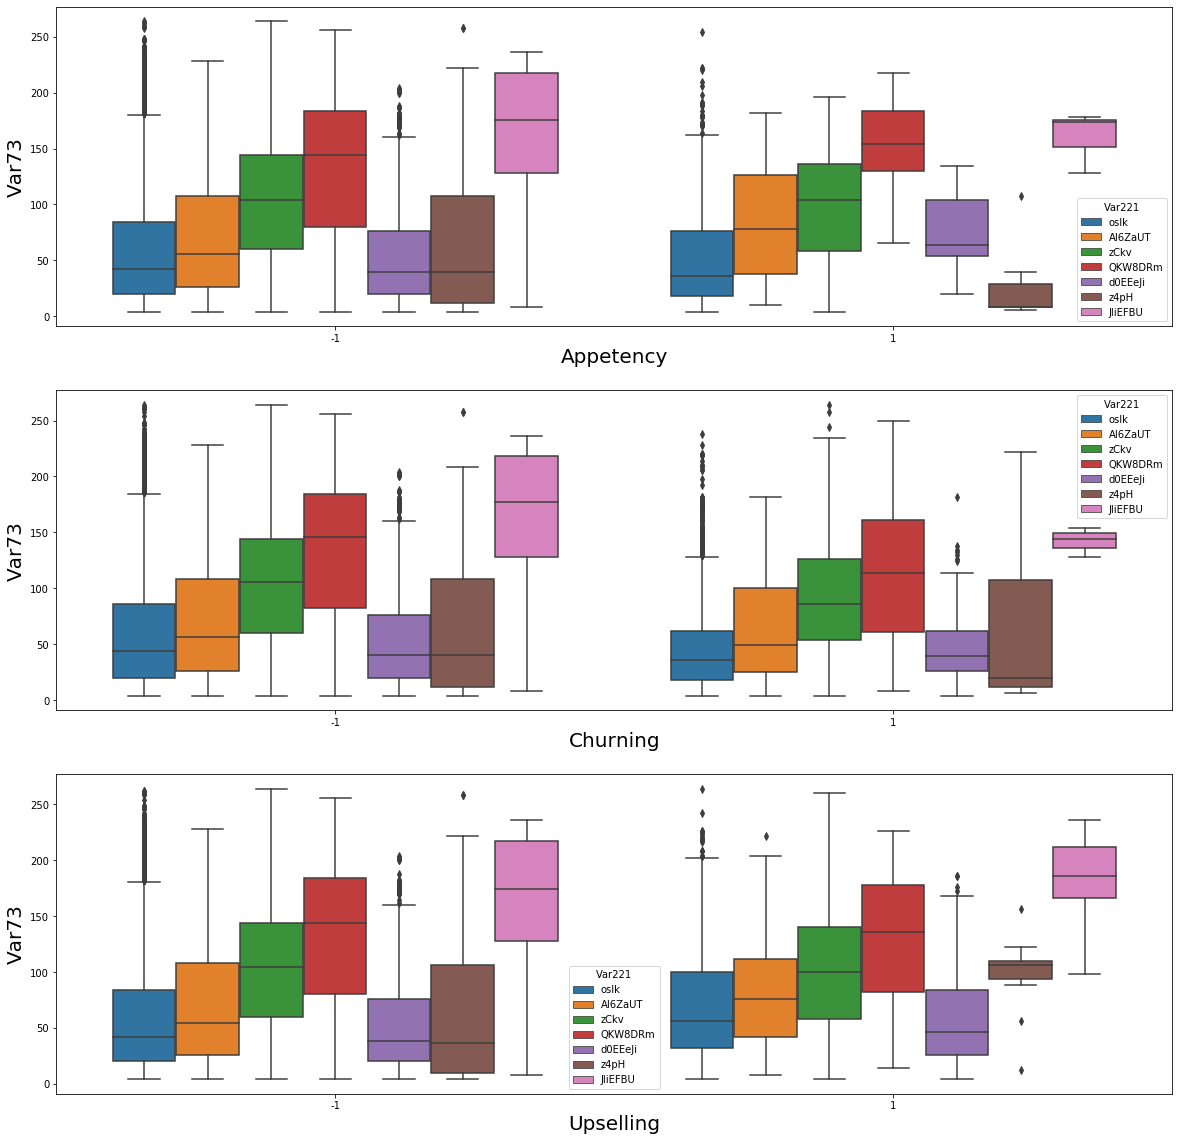

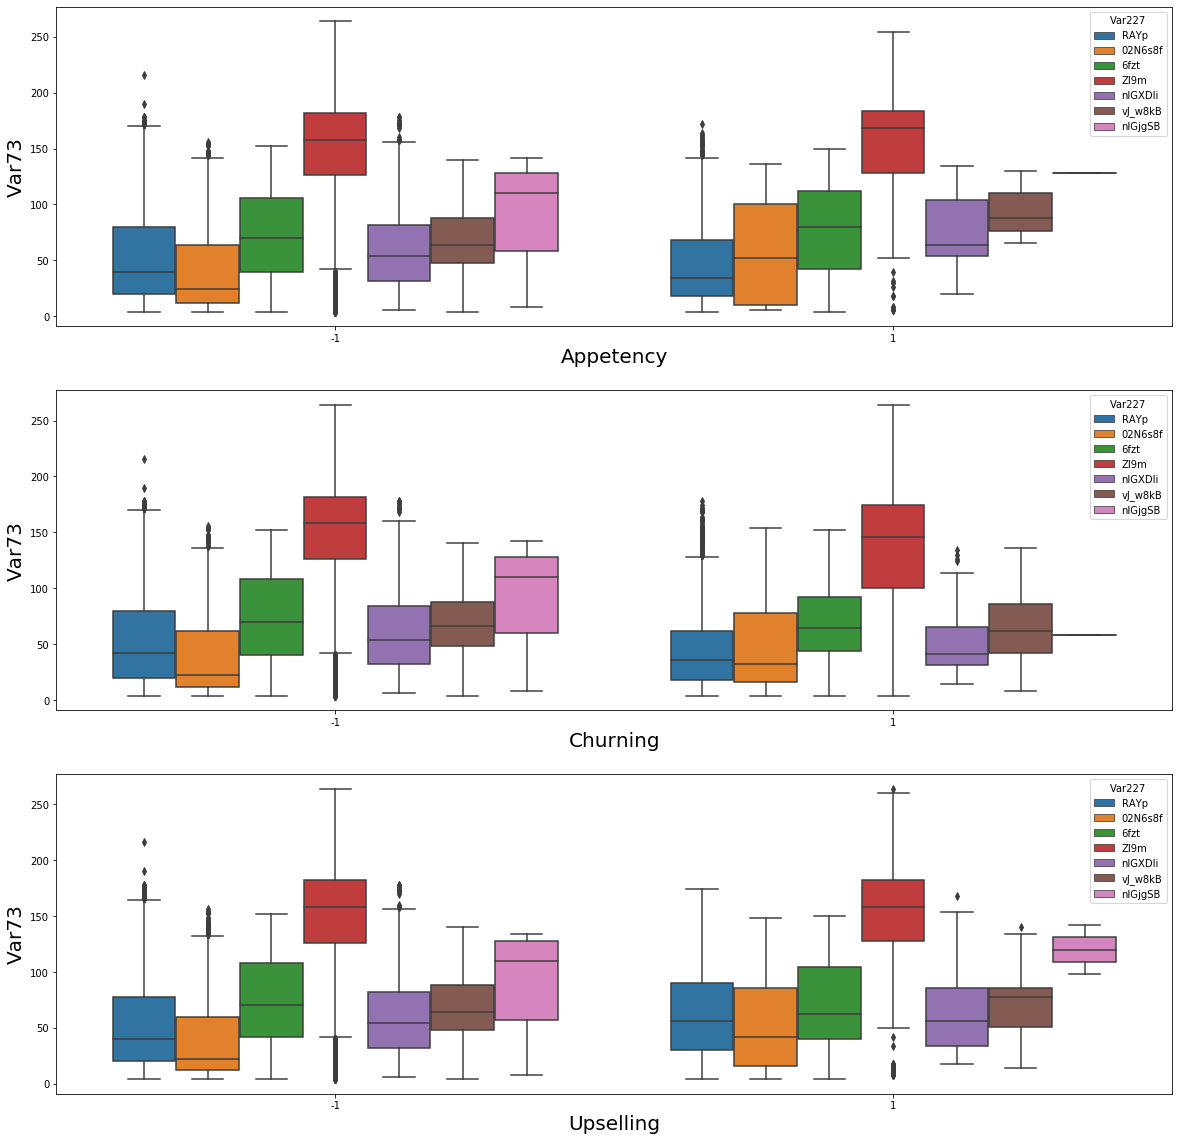

In [126]:
temp = []
for i in cat_var:
    if len(train_data[i].unique())<10:
        temp.append(i)
# the above code snippet stored those features which has less than 10 unique varibles in the column.
# the below code snippet shows the distribution of each variable in the features group by class label
# basically it's comparing the results
# we have done EDA for var73 which is our numerical features.
for col in temp:
    plt.figure(figsize = (20,20))
    plt.subplot(3,1,1)
    sns.boxplot(x = train_data['appetency'],y = train_data['Var73'],hue =train_data[col])
    plt.xlabel("Appetency",fontsize = 20)
    plt.ylabel("Var73",fontsize = 20)
    plt.subplot(3,1,2)
    sns.boxplot(x = train_data['churning'],y = train_data['Var73'],hue =train_data[col])
    plt.xlabel("Churning",fontsize = 20)
    plt.ylabel("Var73",fontsize = 20)
    plt.subplot(3,1,3)
    sns.boxplot(x = train_data['upselling'],y = train_data['Var73'],hue =train_data[col])
    plt.xlabel("Upselling",fontsize = 20)
    plt.ylabel("Var73",fontsize = 20)

1. The above plots shows the boxplot of Unique Variables in Features w.r.t Var73 and group by apptency,churning and upselling labels.
2. This EDA was done to obeserved how well the variables are distributed w.r.t feature Var73 and can we distinguish label -1 and 1 by looking at this variables.
3. But by looking at boxplot hardly we can say anything as many of variable for both class label -1 and 1 have high proportion of collision.
4. And also there are some variable in features which are only present for class label -1 and not for 1.

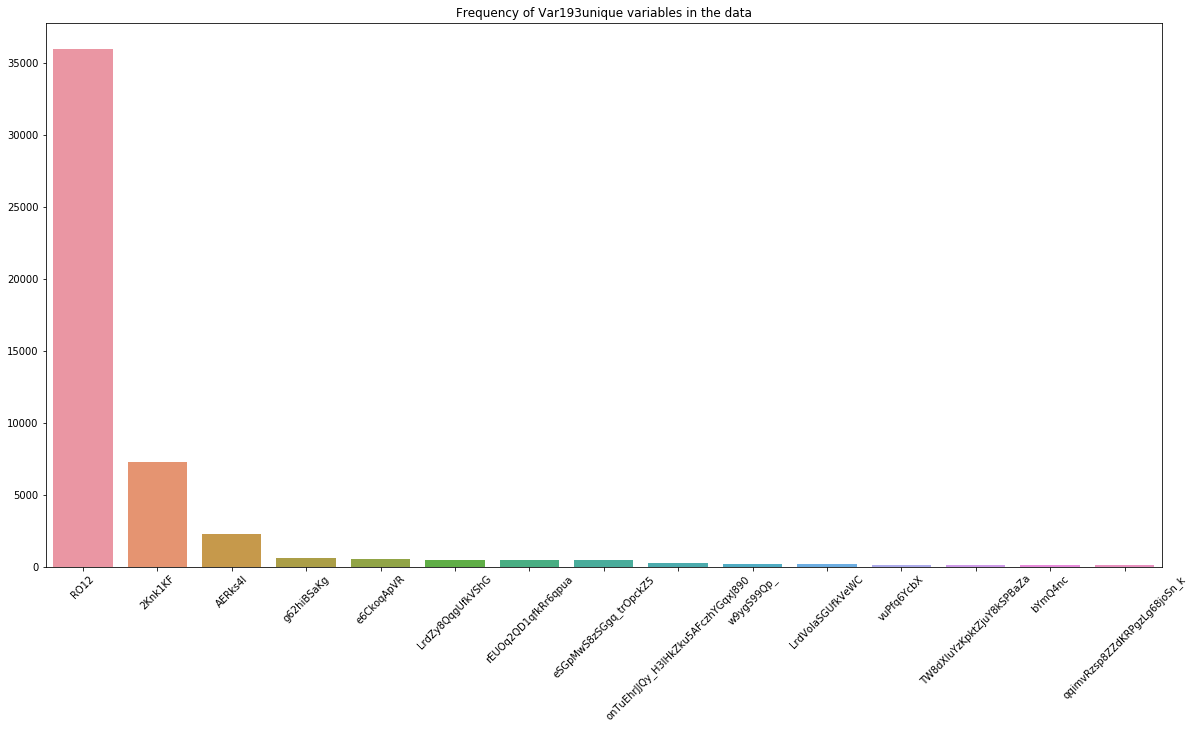

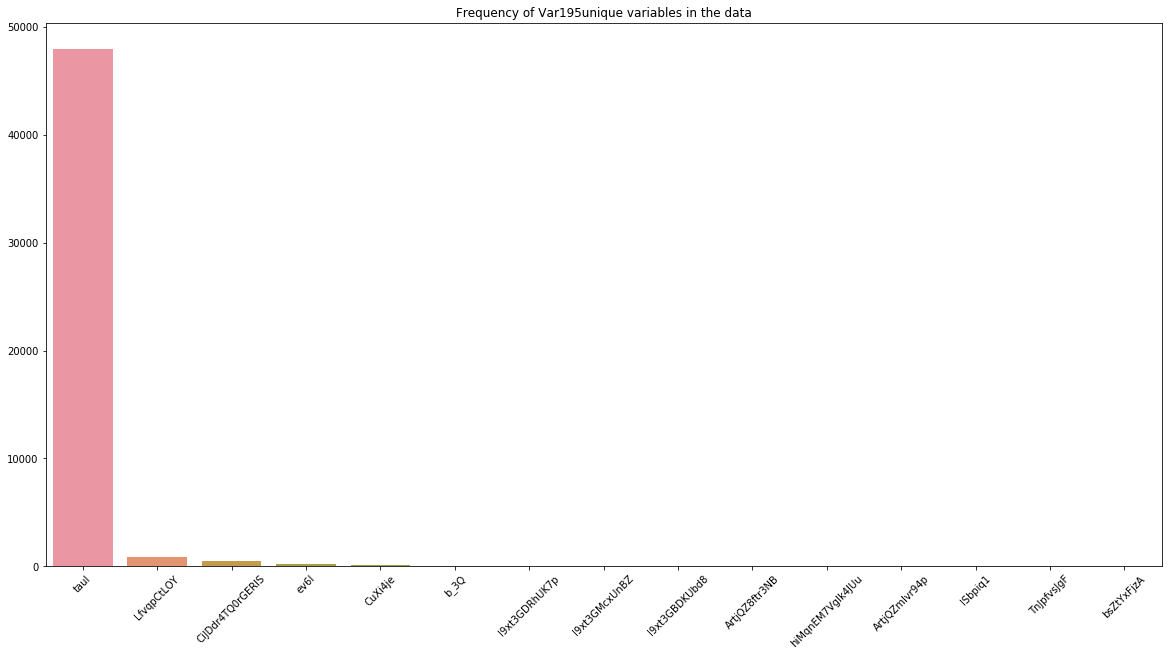

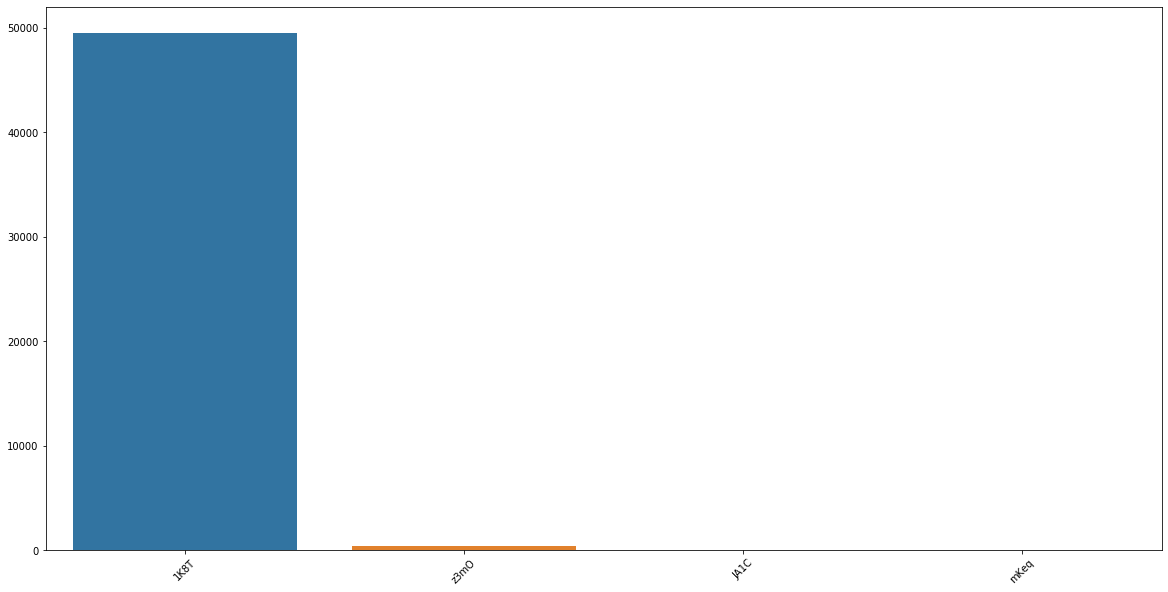

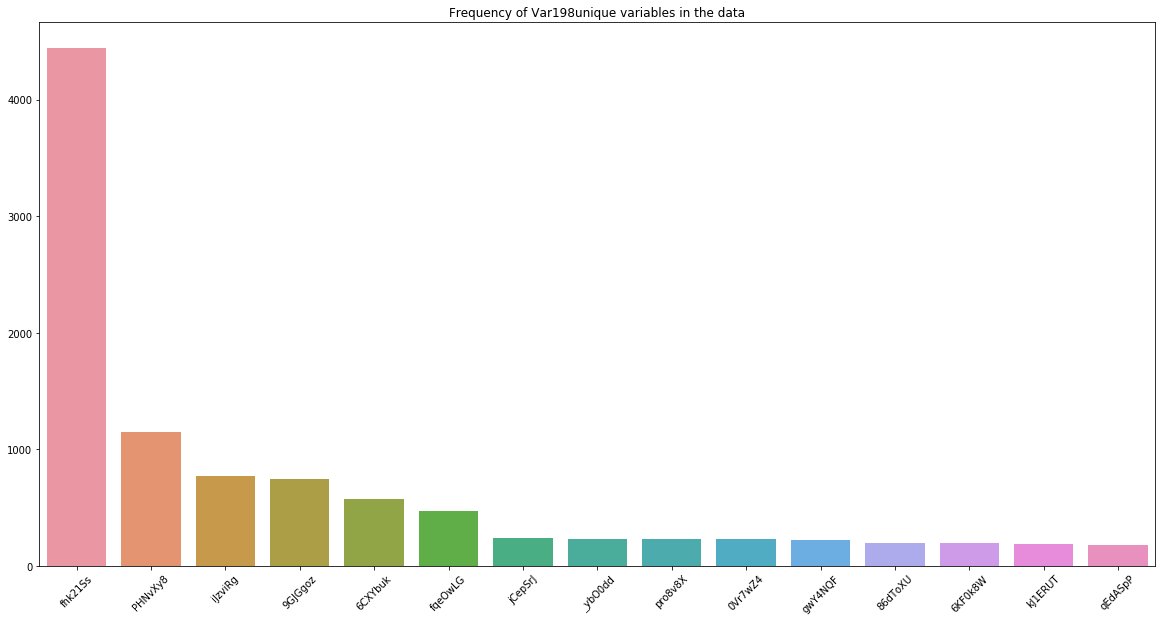

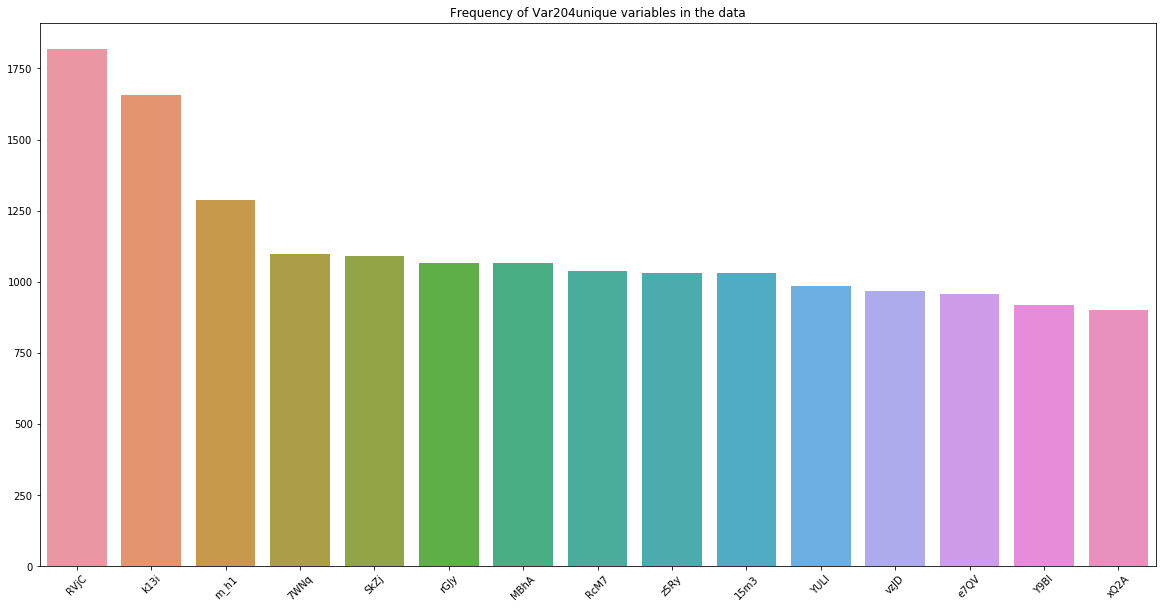

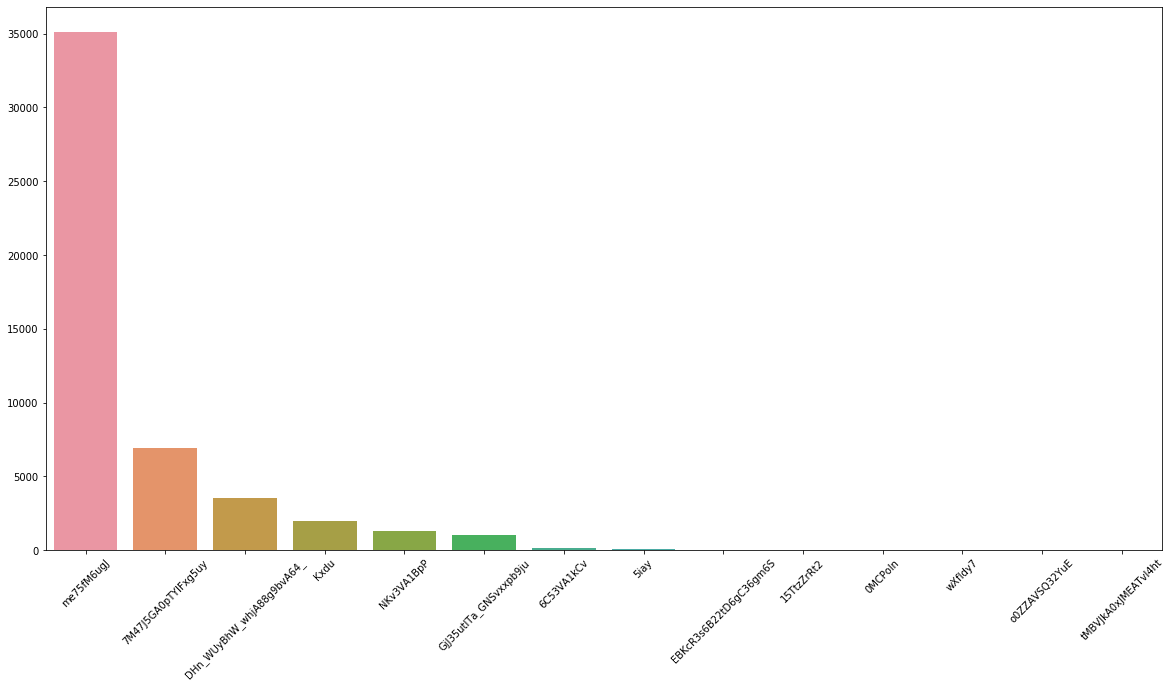

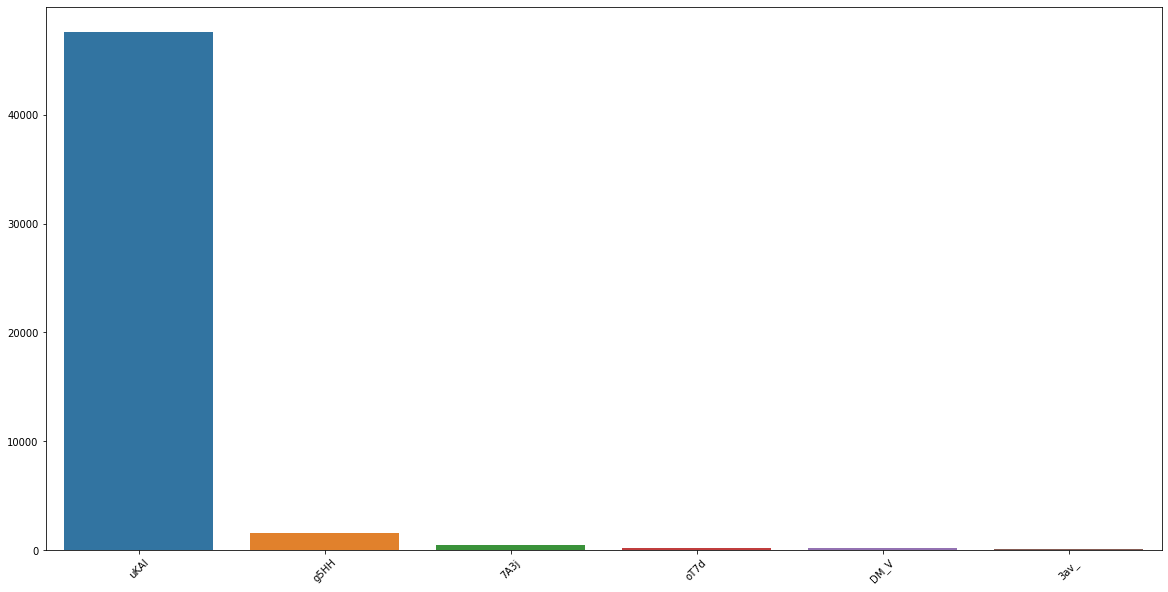

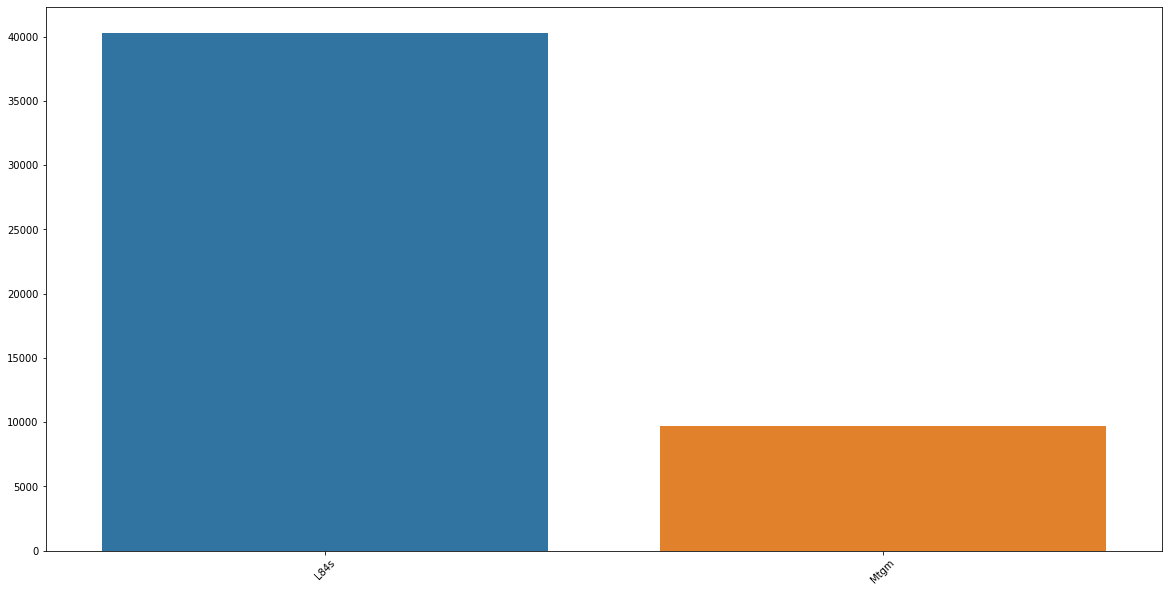

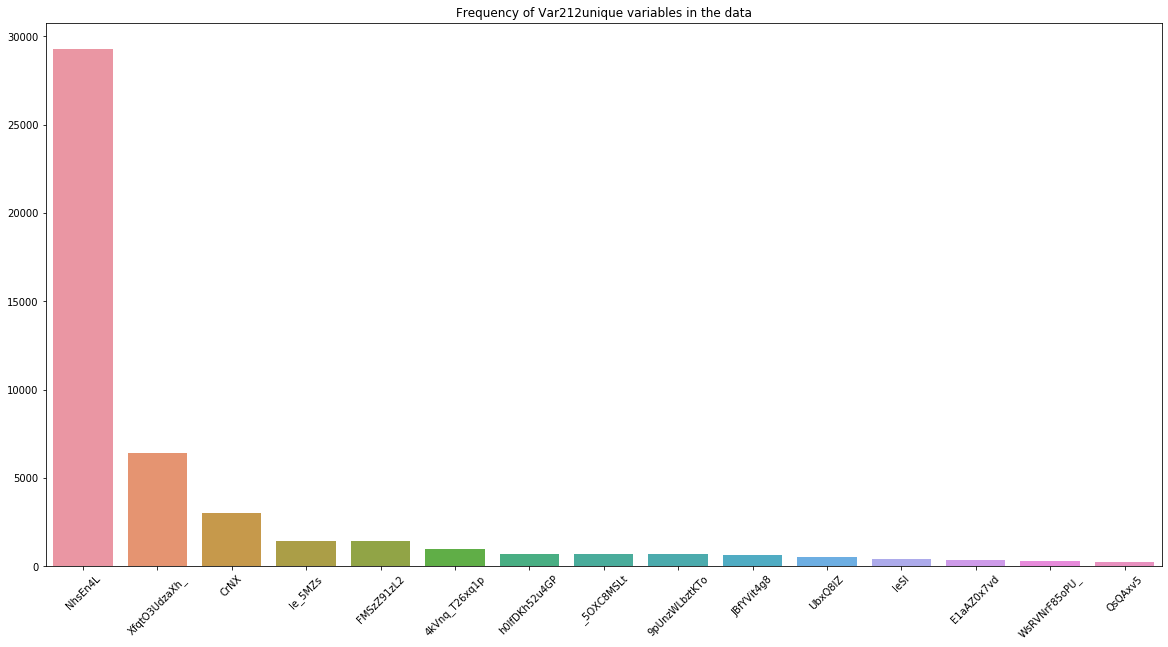

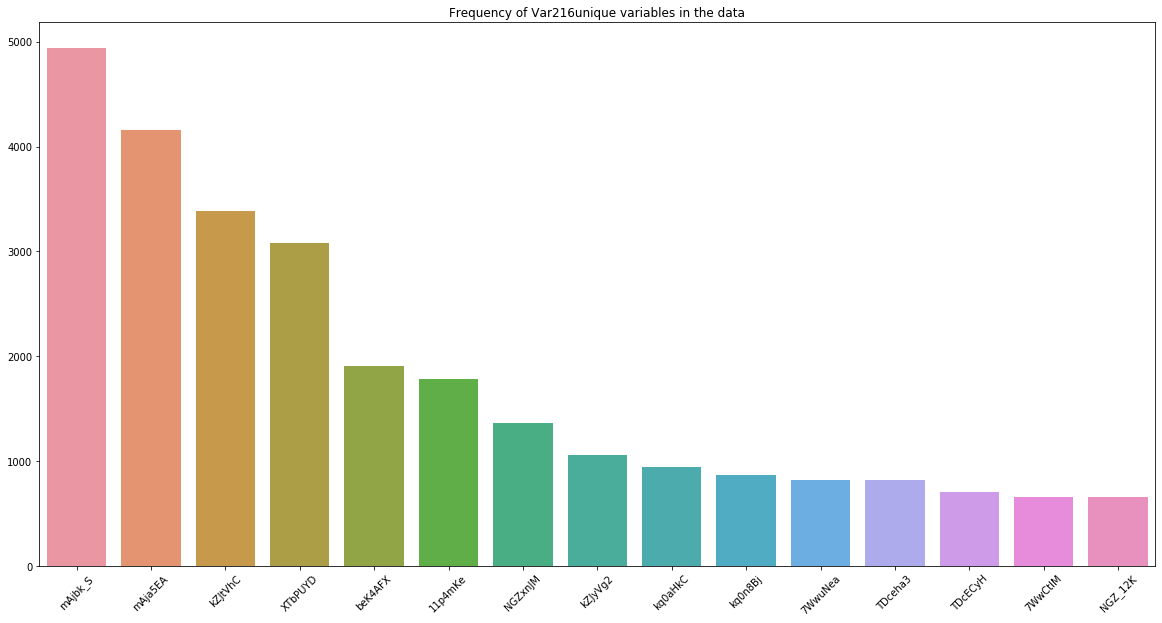

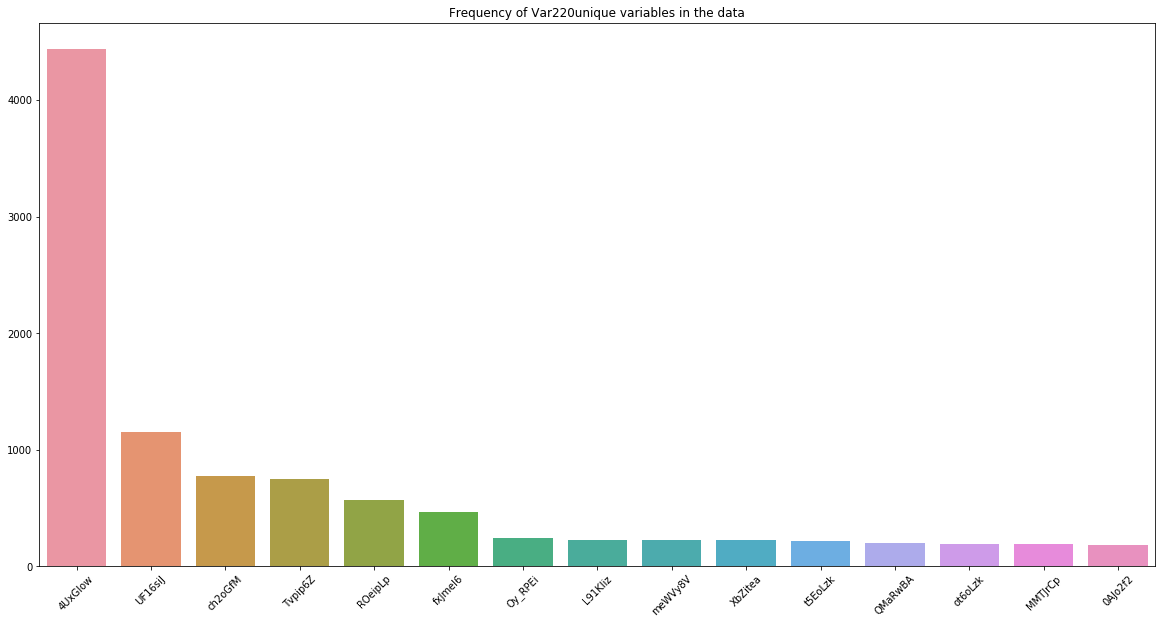

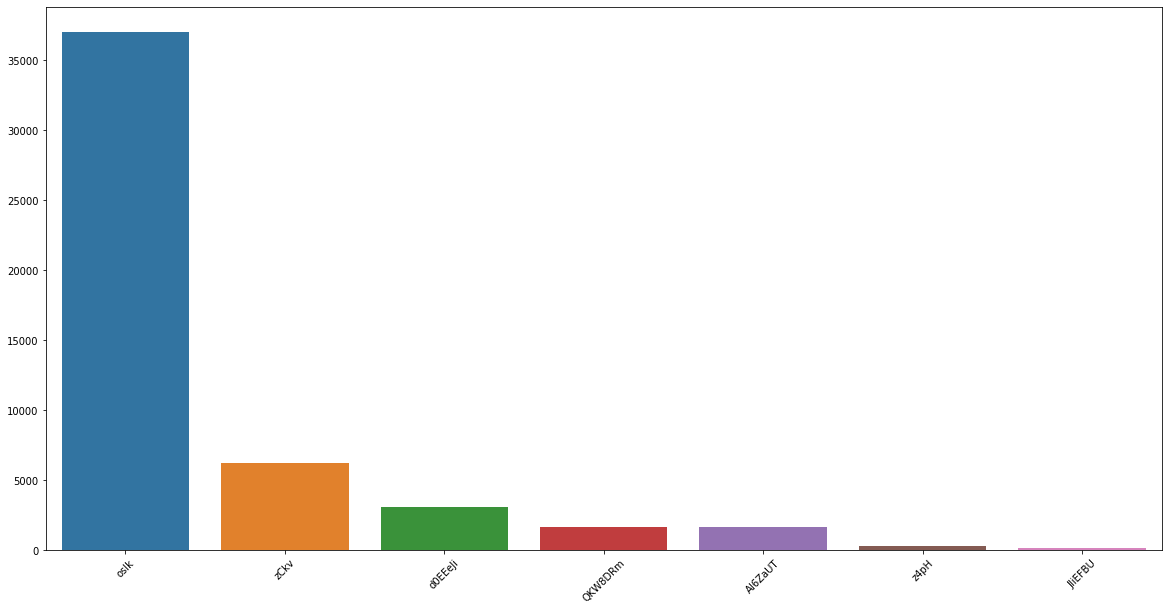

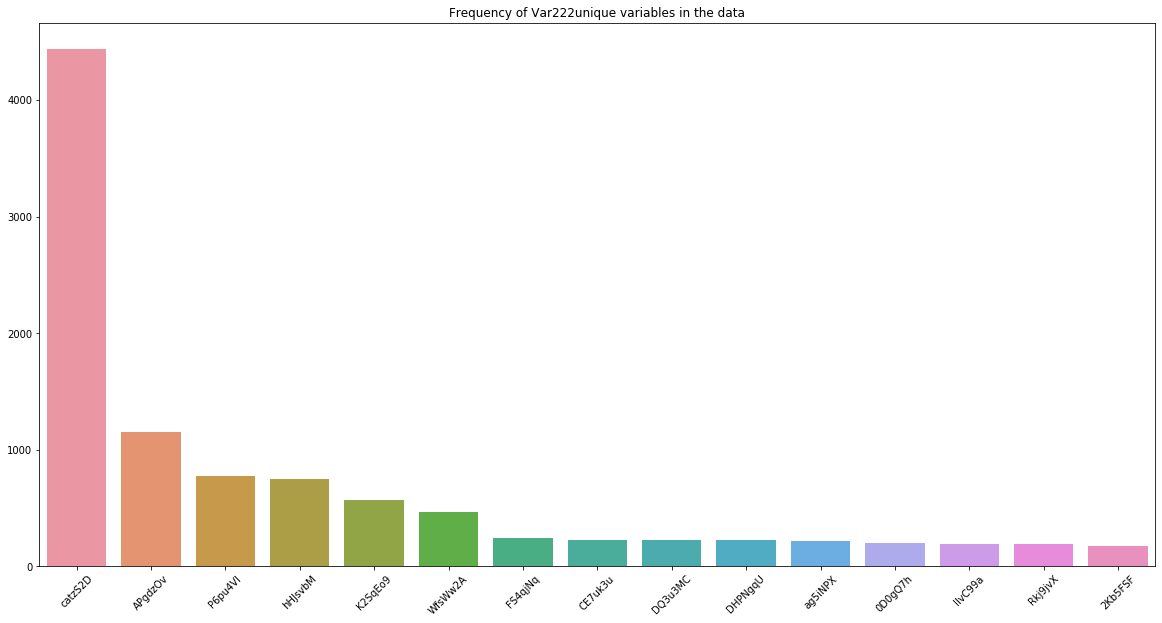

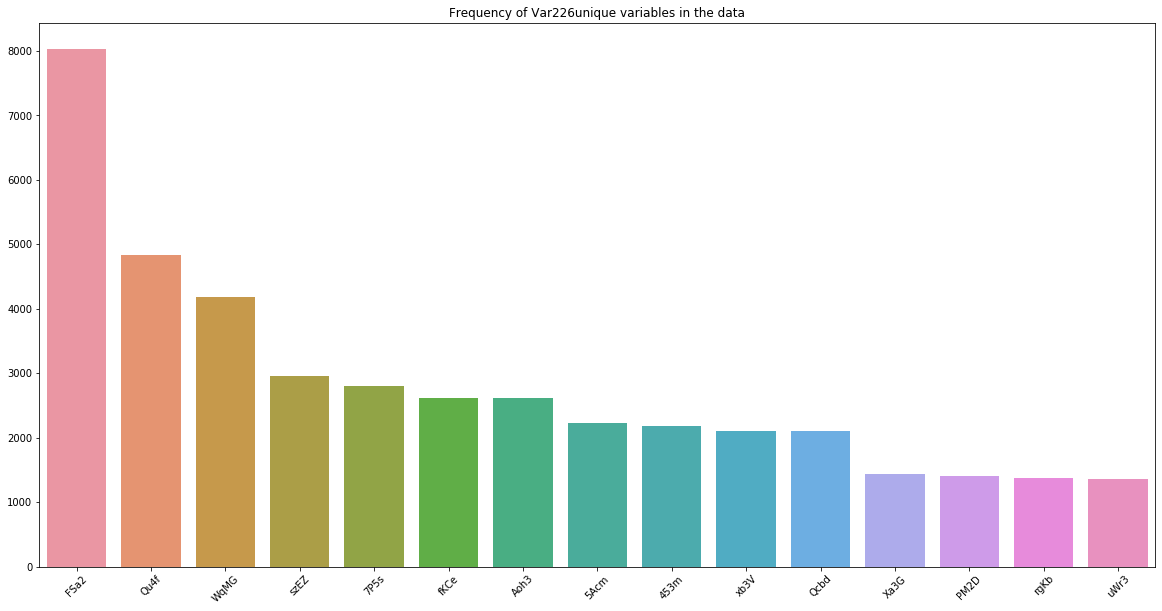

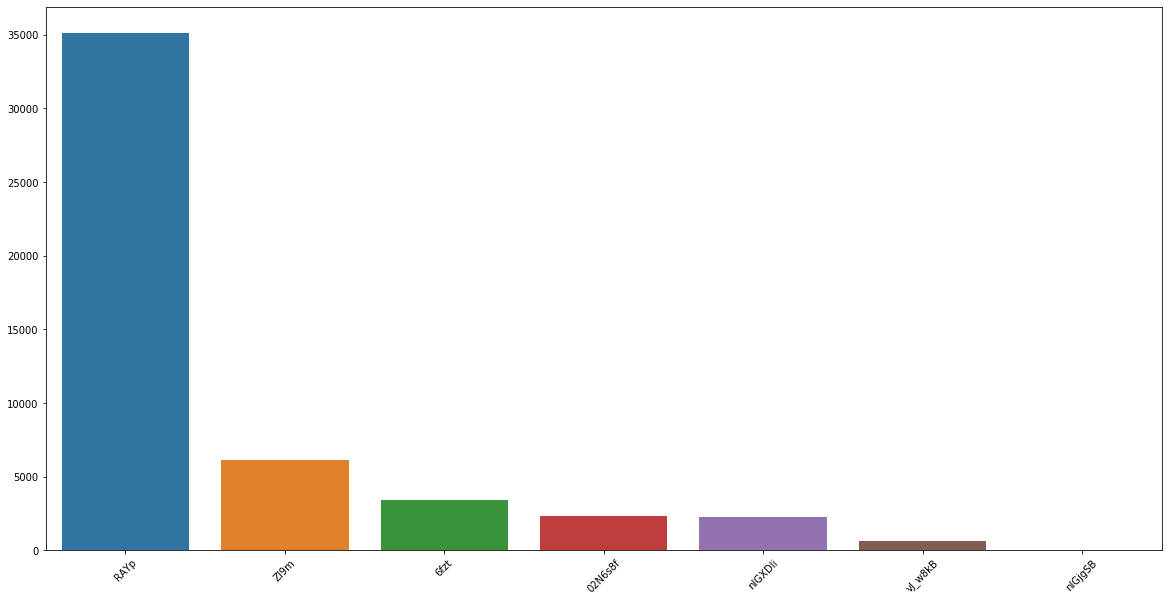

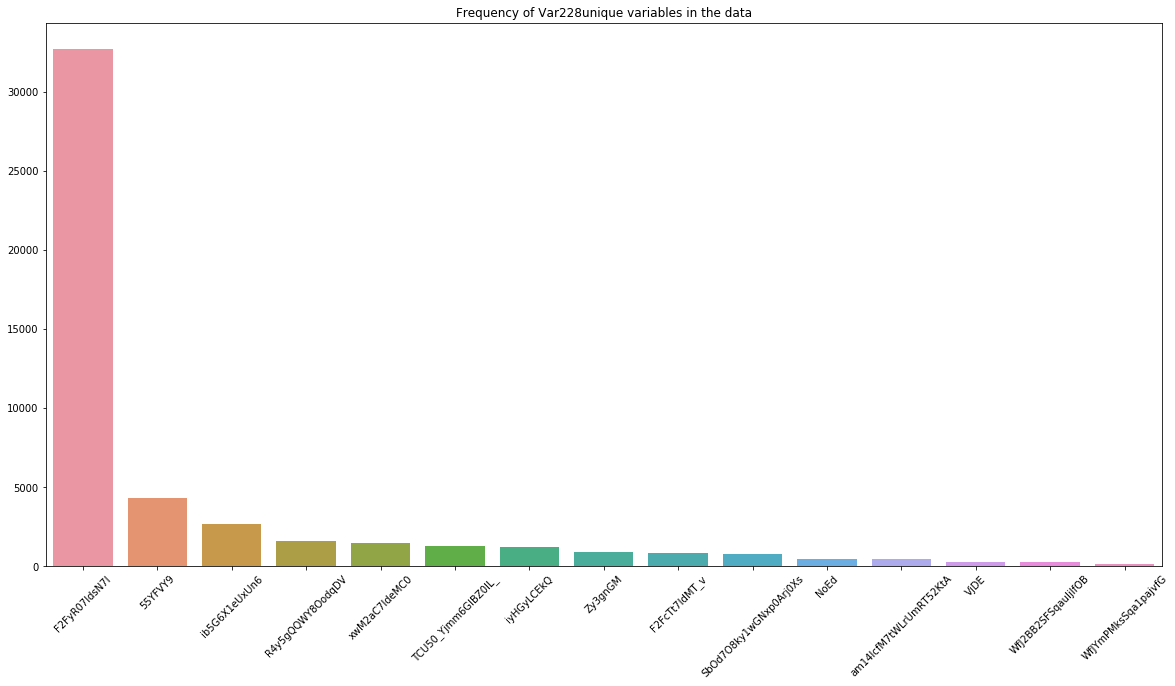

In [128]:
# the below code snippet just plot variable frequency distribution in each features.
for col in cat_var:
    # iterating over categorical variable.
    plt.figure(figsize=(20,10))
    if len(train_data[col].unique())>15:
        sns.barplot(x = train_data[col].value_counts().keys().tolist()[:15],y = train_data[col].value_counts().values.tolist()[:15])
        plt.xticks(rotation = 45)
        plt.title("Frequency of "+col+"unique variables in the data")
    else:
        sns.barplot(x = train_data[col].value_counts().keys().tolist()[:len(train_data[col].unique())],y = train_data[col].value_counts().values.tolist()[:len(train_data[col].unique())])
        plt.xticks(rotation = 45)

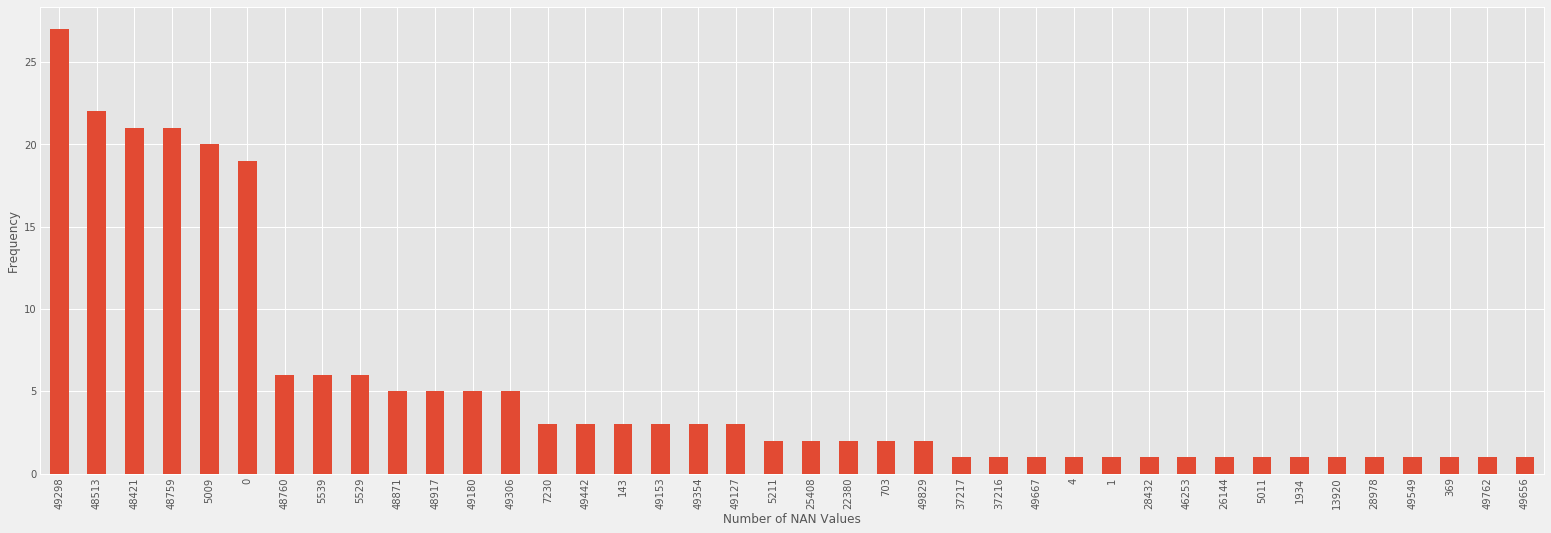

In [63]:
plt.figure(figsize = (24,8))
plt.style.use('ggplot')
na_val_sorted['Total NA values'].value_counts()[:50].plot(kind='bar')
plt.xlabel("Number of NAN Values")
plt.ylabel("Frequency")
plt.show()

 1. Above operation tells us the number of NaN values per columns and followed by frequency of NaN values.
 2. So we can see there are many number of columns which have above 40k NaN values from 50k data.

#### From above plots we have seen there are some columns which have NaN values in all rows so we will remove that columns as that columns is not useful in future prediction.

In [6]:
na_val_sorted["Total NA values"] = na_val_sorted["Total NA values"].map(int)
col_name = list(na_val_sorted[na_val_sorted["Total NA values"]==50000]["Features"])


In [7]:
train_data = train_data.drop(col_name,axis=1) # here we are droping columns having all values as NAN

#### Now we are reading our churn,appetency and up_selling labels data to see the distribution.

In [8]:
appetency = pd.read_table(r"C:\Users\patha\Documents\kdd cup 2009\orange_small_train_appetency.labels",header=None)
churn = pd.read_table(r"C:\Users\patha\Documents\kdd cup 2009\orange_small_train_churn.labels",header=None)
upsell = pd.read_table(r"C:\Users\patha\Documents\kdd cup 2009\orange_small_train_upselling.labels",header = None)

print("Shape of appetency data {} ".format(appetency.shape))
print("Shape of churning data {} ".format(churn.shape))
print("Shape of up selling data {} ".format(upsell.shape))

Shape of appetency data (50000, 1) 
Shape of churning data (50000, 1) 
Shape of up selling data (50000, 1) 


### Let's See the distribution of class or targets

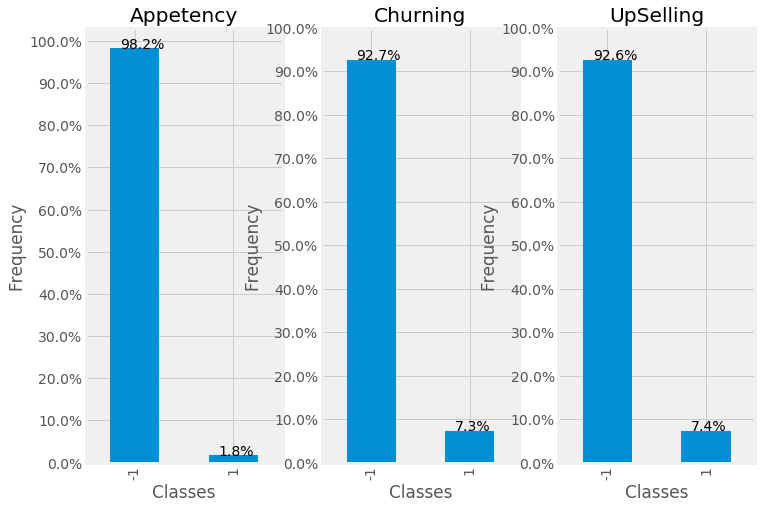

In [10]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')
plt.subplot(1,3,1) # subplot with rows 1 and columns 3
ax = appetency[0].value_counts().plot.bar()
total=50000
for p in ax.patches:
# goto this https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.annotate.html for more info about annotation.
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11)) 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Appetency")
plt.style.use('fivethirtyeight')
plt.subplot(1,3,2)
ax = churn[0].value_counts().plot.bar()
total=50000
for p in ax.patches:
# goto this https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.annotate.html for more info about annotation.
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11)) 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Churning")
plt.style.use('fivethirtyeight')
plt.subplot(1,3,3)
ax = upsell[0].value_counts().plot.bar()
total=50000
for p in ax.patches:
# goto this https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.annotate.html for more info about annotation.
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11)) 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("UpSelling")
plt.show()

#### As we can see from above distribution that each data is highly unbalanced

#### Now we will findout percentage of nan values present in the each column and remove those column which has more than 70% nan values.

In [9]:
na_val_sorted = na_val_sorted.loc[18:].reset_index()
na_val_sorted.drop(['index'],axis=1,inplace=True)

In [10]:
na_val_sorted["percent_of_nan"] = na_val_sorted["Total NA values"]/50000.0

In [11]:
col_drop = list(na_val_sorted[na_val_sorted["percent_of_nan"]>0.70]["Features"])  # index of columns to be dropped from the data
train_data = train_data.drop(col_drop,axis=1)

In [12]:
train_data.sample(5)

Var6  Var7   Var13  Var21  Var22  Var24  Var25   Var28  Var35  \
23768   630.0   0.0     0.0  124.0  155.0    0.0    0.0  220.08    0.0   
28160  2226.0   7.0   428.0  264.0  330.0    4.0   48.0  220.48    0.0   
31725  2499.0   7.0  2036.0  436.0  545.0   14.0  304.0  166.56    0.0   
38769   980.0   7.0    32.0   96.0  120.0    0.0   32.0  330.24    0.0   
24482     0.0   0.0     0.0    0.0    0.0    NaN    0.0  391.12    0.0   

            Var38  ...  Var219   Var220  Var221   Var222      Var223  Var225  \
23768  11404800.0  ...    qxDb  KPauwyX    oslk  F7_Q2Sy  LM8l689qOp     NaN   
28160    367500.0  ...    FzaX  JptRsCb    oslk  2wCqs0R  LM8l689qOp     NaN   
31725         0.0  ...    FzaX  4UxGlow    zCkv  catzS2D  LM8l689qOp    kG3k   
38769    799134.0  ...    FzaX  zqsoLzk    oslk  WRysKoy  LM8l689qOp     NaN   
24482         0.0  ...    FzaX  meWVy8V    oslk  DQ3u3MC  LM8l689qOp     NaN   

       Var226  Var227         Var228  Var229  
23768    3Cy4    RAYp  F2FyR07IdsN7I     NaN  
28160    me1d    RAYp  F2FyR07IdsN7I    am7c  
31725    3Cy4    ZI9m           NoEd    mj86  
38769    xb3V    RAYp  F2FyR07IdsN7I     NaN  
24482    Qu4f    RAYp  F2FyR07IdsN7I     NaN  

[5 rows x 74 columns]

#### Now we will see how many unique values are there in each features or columns.

In [13]:
columns_data = list(train_data.columns)
freq = []
for col in columns_data:
    freq.append(len(train_data[col].value_counts().index))

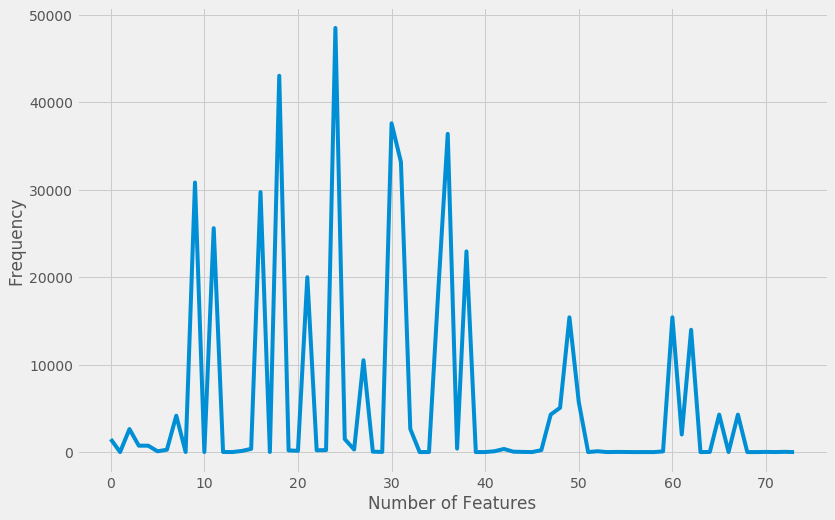

In [16]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x =list(np.arange(len(columns_data))),y=freq)
plt.xlabel("Number of Features")
plt.ylabel("Frequency")
plt.show()

### Splitting the dataset into training and test data in the ratio of 80:20

In [14]:
%%time
from sklearn.model_selection import train_test_split
# appetency data
X_train_app,X_test_app,y_train_app,y_test_app = train_test_split(train_data,appetency,test_size=0.2,random_state=112,stratify = appetency)
# churning data
X_train_churn,X_test_churn,y_train_churn,y_test_churn = train_test_split(train_data,churn,test_size=0.2,random_state=112,stratify = churn)
#upselling data
X_train_up,X_test_up,y_train_up,y_test_up = train_test_split(train_data,upsell,test_size=0.2,random_state=112,stratify = upsell)

Wall time: 1.09 s


In [15]:
print("Appetency train data shape is {} and test data shape is {}".format(X_train_app.shape,X_test_app.shape))
print("Churning train data shape is {} and test data shape is {}".format(X_train_churn.shape,X_test_churn.shape))
print("Upselling train data shape is {} and test data shape is {}".format(X_train_up.shape,X_test_up.shape))

Appetency train data shape is (40000, 74) and test data shape is (10000, 74)
Churning train data shape is (40000, 74) and test data shape is (10000, 74)
Upselling train data shape is (40000, 74) and test data shape is (10000, 74)


In [16]:
# seperating categorical and numerical features for simplification.
column = [] # categorical features
int_column = [] # numerical features
for col in X_train_app.columns:
    if X_train_app[col].dtype=='O':
        column.append(col)
    else:
        int_column.append(col)

#### Lets start with some feature engineering
#### Lets first Counter the problem of NaN values in numerical and categorical data.

#### 1st Feature Engineering Techniques

In [17]:
# this function create new columns or features which is a binary features which tells whether the value present in the column 
# is nan or not.
def binary_feat(dataframe):
    column = list(dataframe.columns) # storing the columns of dataframe passed as a parameter
    
    for col in column:
        is_binary=[] # a list to store binary feature 0 and 1
        lst = list(dataframe[col].isna())
        for i in lst:
            if i == False:
                is_binary.append(0)
            else:
                is_binary.append(1)
        dataframe["is_"+col] = is_binary  # creating new feature is_column_name and adding to dataframe
    return(dataframe)

In [18]:
%%time
# calling each train and test dataset for appetency ,upselling and churning.
X_train_app = binary_feat(X_train_app)
X_test_app = binary_feat(X_test_app)
X_train_churn = binary_feat(X_train_churn)
X_test_churn = binary_feat(X_test_churn)
X_train_up = binary_feat(X_train_up)
X_test_up = binary_feat(X_test_up)


Wall time: 4.61 s


In [87]:
new_col = X_train_app.columns[75:-1].tolist()
data = {} # dictionary to store each features as a key and number of nan values in that feature as 
for col in new_col:
    if 1 in X_train_app[col].value_counts().index:
        data[col] = X_train_app[col].value_counts()[1]
    else:
        data[col] = 0
#X_train_app[new_col[0]].value_counts()[1]

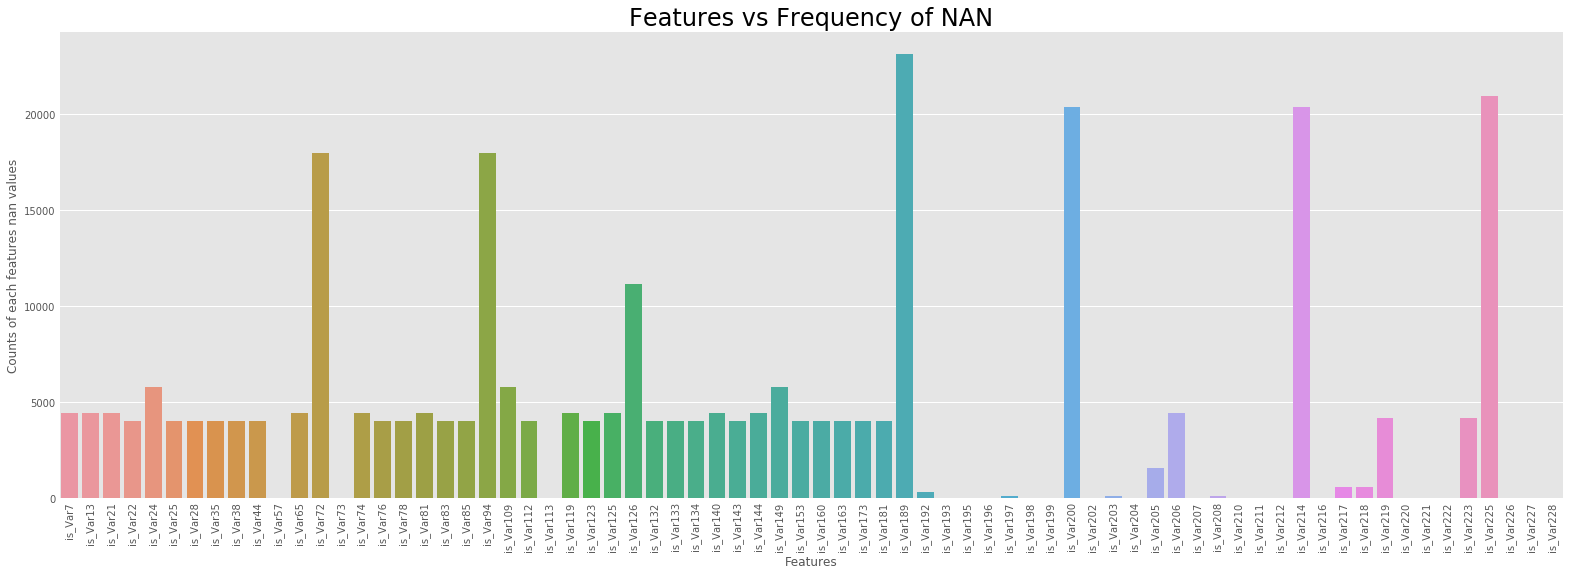

In [204]:
plt.figure(figsize = (24,8))
sns.barplot(x = new_col,y = list(data.values()))
plt.xticks(rotation = 90)
plt.xlabel("Features")
plt.ylabel("Counts of each features nan values")
plt.title("Features vs Frequency of NAN",fontsize = 24)
plt.show()


#### 2nd Feature Engineering Techniques

In [19]:
%%time
# this function add new feature of number of nan values present in each rows.
def cal_nan(dataframe):
    appetency_bool = dataframe.apply(lambda x:x.isna()) 
    index = list(dataframe.index)
    row_nan = [] # count of number of nan values in each rows.
    for indx in index:
        if True in appetency_bool.loc[indx].value_counts():
            row_nan.append(appetency_bool.loc[indx].value_counts()[True])
        else:
            row_nan.append(0)
    dataframe["freq_nan"] = row_nan # at last creating new feature in the data with the info of number of nans in each row.
    return(dataframe)

Wall time: 0 ns


In [20]:
%%time
# calling each train and test dataset for appetency ,upselling and churning.
X_train_app = cal_nan(X_train_app)
X_test_app = cal_nan(X_test_app)
X_train_churn = cal_nan(X_train_churn)
X_test_churn = cal_nan(X_test_churn)
X_train_up = cal_nan(X_train_up)
X_test_up = cal_nan(X_test_up)


Wall time: 3min 43s


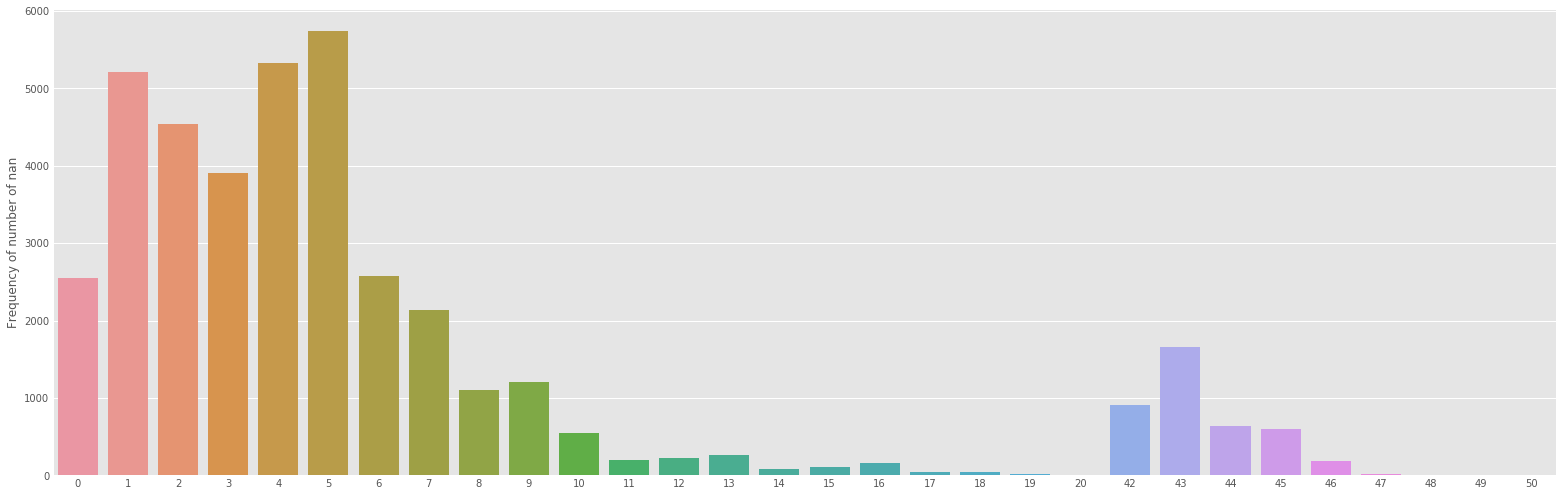

In [206]:
plt.figure(figsize = (24,8))
data = dict(X_train_app['freq_nan'].value_counts()) # this dictionary contains number of nan in a row as a key and frequency of that as value
sns.barplot(x = list(data.keys()),y = list(data.values()))
plt.ylabel("Frequency of number of nan")
plt.show()
#this plot result shows how many number of times nan's values are present in a row i.e how many times a row contains 5 nans
# values in a data.

### Taking NaN as different Group

In [ ]:
# for each categorical data types features we consider NaNs values as a seperate group.
def convert_nan(df):
    for col in column:
        df[col] = pd.Series(np.where(df[col].isnull(),"Others",df[col].values)).tolist()
    return(df)
# in the above function we have consider each nan values and cluster it into one group for categorical data features.

In [ ]:
%%time
X_train_app = convert_nan(X_train_app)
X_test_app = convert_nan(X_test_app)
X_train_churn = convert_nan(X_train_churn)
X_test_churn = convert_nan(X_test_churn)
X_train_up = convert_nan(X_train_up)
X_test_up = convert_nan(X_test_up)

## Encoding of categorical features

### Encoding Top 5 Values Of Each Features 

In [21]:
%%time
# taking top 5 variables of each categorical features and encoding them.Later we will also do frequency enoding to replace categorical features.
def encoding(column,df,temp):
    for col in column:
        for var in list(dict(temp[col].value_counts()[:5]).keys()):
            df[col+"_"+var] = list(np.where(df[col].str.contains(var),1,0)) # this where function works like if else if condition satified it give value as 1 else 0
    return(df)

Wall time: 0 ns


In [22]:
%%time
# calling each train and test dataset for appetency ,upselling and churning.
X_train_app = encoding(column,X_train_app,X_train_app)
X_train_churn = encoding(column,X_train_churn,X_train_churn)
X_train_up = encoding(column,X_train_up,X_train_up)
X_test_app = encoding(column,X_test_app,X_train_app)
X_test_churn = encoding(column,X_test_churn,X_train_churn)
X_test_up = encoding(column,X_test_up,X_train_up)

Wall time: 20.9 s


1. Above categorical encoding feature engineering can be done using top 10 variables of features but i have taken top 5 variables.

### Frequency Encoding

In [23]:
def freq_encoding(df_tr,temp_df,column): # this frequency encoding replacing each categorical variables with there number of occurence in the 
                            # features and later normalizing it.
    #i=0
    for col in column:
        start = datetime.now()
        value = dict(df_tr[col].value_counts()) # having value counts data from training data only
        data = []
        for val in temp_df[col].values: 
            if val not in list(value.keys()):
                data.append(1) # if certain variable is not present in test data then append that 1 for that new variable.
            else:
                data.append(value[val])
        temp_df[col] = data
        #i+=1
        #print("iteration {} -> {}".format(i,datetime.now() - start))
    return(temp_df)

In [24]:
%%time
# calling each train and test dataset for appetency ,upselling and churning.
X_train_app= freq_encoding(X_train_app,X_train_app,column)
X_test_app= freq_encoding(X_train_app,X_test_app,column)
X_train_churn= freq_encoding(X_train_churn,X_train_churn,column)
X_test_churn= freq_encoding(X_train_churn,X_test_churn,column)
X_train_up= freq_encoding(X_train_up,X_train_up,column)
X_test_up= freq_encoding(X_train_up,X_test_up,column)

Wall time: 2min 11s


In [25]:
print(X_train_app.shape)
print(X_train_churn.shape)
print(X_train_up.shape)

(40000, 293)
(40000, 293)
(40000, 292)


### Filling NA Values

In [26]:
# the below code snippet filling na values 
# we are storing train data in temp_df because temp_df variable will be used to calculate mean and we can't use test data for 
# mean calculation as it will data leakage problem.
def fill_na(df_tr,temp_df,column):
    for col in column:
        df_tr[col].fillna(temp_df[col].mean(),inplace = True)
    return(df_tr)

In [27]:
%%time
# calling each train and test dataset for appetency ,upselling and churning.
X_train_app = fill_na(X_train_app,X_train_app,int_column)
X_test_app = fill_na(X_test_app,X_train_app,int_column)
X_train_churn = fill_na(X_train_churn,X_train_churn,int_column)
X_test_churn = fill_na(X_test_churn,X_train_churn,int_column)
X_train_up = fill_na(X_train_up,X_train_up,int_column)
X_test_up = fill_na(X_test_up,X_train_up,int_column)

Wall time: 141 ms


### Now we are normalizing each column using min-max scaling

#### Appetency Dataset

In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# MinMaxScaler(feature_range=(0, 1), copy=True)
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler() # we are doing min max scaling to ensure all values lie between 0 and 1
train = minmax.fit_transform(X_train_app)
test = minmax.transform(X_test_app)

In [29]:
X_train_app = pd.DataFrame(train,columns = X_train_app.columns)
X_train_app.sample(5)
X_test_app = pd.DataFrame(test,columns = X_test_app.columns)
X_test_app.sample(5)

Var6      Var7     Var13     Var21     Var22     Var24     Var25  \
9614  0.011467  0.048761  0.006279  0.006454  0.006386  0.009115  0.007371   
2988  0.058169  0.050000  0.000040  0.004080  0.004080  0.000000  0.003645   
7978  0.006510  0.050000  0.003679  0.003749  0.003749  0.000000  0.008505   
9500  0.011467  0.048761  0.006279  0.006454  0.006386  0.009115  0.007371   
7112  0.013629  0.050000  0.000303  0.008381  0.008381  0.008097  0.006683   

         Var28     Var35     Var38  ...  Var227_nIGXDli  Var228_F2FyR07IdsN7I  \
9614  0.092864  0.012041  0.142081  ...             0.0                   1.0   
2988  0.110548  0.000000  0.243719  ...             0.0                   0.0   
7978  0.103793  0.000000  0.285000  ...             0.0                   0.0   
9500  0.092864  0.012041  0.142081  ...             0.0                   1.0   
7112  0.074378  0.000000  0.000147  ...             0.0                   1.0   

      Var228_55YFVY9  Var228_ib5G6X1eUxUn6  Var228_R4y5gQQWY8OodqDV  \
9614             0.0                   0.0                      0.0   
2988             1.0                   0.0                      0.0   
7978             0.0                   0.0                      0.0   
9500             0.0                   0.0                      0.0   
7112             0.0                   0.0                      0.0   

      Var228_xwM2aC7IdeMC0  Var229_am7c  Var229_mj86  Var229_sk2h  Var229_oJmt  
9614                   0.0          1.0          1.0          1.0          1.0  
2988                   0.0          0.0          1.0          0.0          0.0  
7978                   1.0          1.0          1.0          1.0          1.0  
9500                   0.0          1.0          1.0          1.0          1.0  
7112                   0.0          1.0          1.0          1.0          1.0  

[5 rows x 293 columns]

#### Churning Data

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# MinMaxScaler(feature_range=(0, 1), copy=True)
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train = minmax.fit_transform(X_train_churn)
test = minmax.transform(X_test_churn)
# It's good to use minmax scaler for scaling as many feature selection technique won't work for negative variable which
# standard scaling gives.

In [31]:
X_train_churn = pd.DataFrame(train,columns = X_train_churn.columns)
X_train_churn.sample(5)
X_test_churn = pd.DataFrame(test,columns = X_test_churn.columns)
X_test_churn.sample(5)

Var6  Var7     Var13     Var21     Var22     Var24     Var25  \
7055  0.003028  0.00  0.000000  0.246140  0.246140  0.004049  0.277035   
312   0.028051  0.00  0.000950  0.009263  0.009263  0.008097  0.015188   
8444  0.006163  0.05  0.002810  0.002647  0.002647  0.000000  0.004253   
5510  0.010307  0.05  0.000162  0.007940  0.007940  0.012146  0.009721   
5306  0.010253  0.15  0.031030  0.005293  0.005293  0.016194  0.010936   

         Var28     Var35     Var38  ...  Var227_nIGXDli  Var228_F2FyR07IdsN7I  \
7055  0.054992  0.045455  0.476704  ...             0.0                   1.0   
312   0.012799  0.000000  0.223090  ...             0.0                   1.0   
8444  0.057473  0.000000  0.084971  ...             0.0                   1.0   
5510  0.044674  0.000000  0.000211  ...             0.0                   1.0   
5306  0.051073  0.000000  0.003128  ...             0.0                   0.0   

      Var228_55YFVY9  Var228_ib5G6X1eUxUn6  Var228_R4y5gQQWY8OodqDV  \
7055             0.0                   0.0                      0.0   
312              0.0                   0.0                      0.0   
8444             0.0                   0.0                      0.0   
5510             0.0                   0.0                      0.0   
5306             0.0                   0.0                      0.0   

      Var228_xwM2aC7IdeMC0  Var229_am7c  Var229_mj86  Var229_sk2h  Var229_oJmt  
7055                   0.0          1.0          1.0          1.0          1.0  
312                    0.0          1.0          1.0          1.0          1.0  
8444                   0.0          0.0          1.0          0.0          0.0  
5510                   0.0          0.0          1.0          0.0          0.0  
5306                   0.0          1.0          0.0          0.0          0.0  

[5 rows x 293 columns]

#### UpSelling Data

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# MinMaxScaler(feature_range=(0, 1), copy=True)
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train = minmax.fit_transform(X_train_up)
test = minmax.transform(X_test_up)
# It's good to use minmax scaler for scaling as many feature selection technique won't work for negative variable which
# standard scaling gives.

In [33]:
X_train_up = pd.DataFrame(train,columns = X_train_up.columns)
X_train_up.sample(5)
X_test_up = pd.DataFrame(test,columns = X_test_up.columns)
X_test_up.sample(5)

Var6  Var7     Var13     Var21     Var22     Var24     Var25  \
2964  0.004091  0.10  0.006691  0.000772  0.000772  0.000000  0.000000   
2075  0.014344  0.05  0.006327  0.000000  0.000000  0.009037  0.000000   
4     0.031504  0.05  0.002871  0.020622  0.020622  0.028340  0.052248   
2864  0.003241  0.05  0.000445  0.001985  0.001985  0.016194  0.000608   
7045  0.006800  0.10  0.050214  0.002426  0.002426  0.004049  0.003038   

         Var28  Var35     Var38  ...  Var227_nIGXDli  Var228_F2FyR07IdsN7I  \
2964  0.061315    0.0  0.420865  ...             0.0                   1.0   
2075  0.051073    0.0  0.000000  ...             0.0                   1.0   
4     0.042683    0.0  0.002254  ...             0.0                   1.0   
2864  0.038274    0.0  0.000000  ...             0.0                   0.0   
7045  0.038274    0.0  0.001582  ...             0.0                   1.0   

      Var228_55YFVY9  Var228_ib5G6X1eUxUn6  Var228_R4y5gQQWY8OodqDV  \
2964             0.0                   0.0                      0.0   
2075             0.0                   0.0                      0.0   
4                0.0                   0.0                      0.0   
2864             0.0                   0.0                      0.0   
7045             0.0                   0.0                      0.0   

      Var228_xwM2aC7IdeMC0  Var229_am7c  Var229_mj86  Var229_oJmt  Var229_sk2h  
2964                   0.0          1.0          1.0          1.0          1.0  
2075                   0.0          1.0          0.0          0.0          0.0  
4                      0.0          0.0          1.0          0.0          0.0  
2864                   0.0          0.0          1.0          0.0          0.0  
7045                   0.0          0.0          1.0          0.0          0.0  

[5 rows x 292 columns]

### Model Training

### Random Forrest on Appetency data

In [365]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [368]:
%%time
# for more info about random forest goto https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# there are many other parameters 
#RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
#, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
#bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


model = RandomForestClassifier(random_state=112,n_jobs=-1,oob_score=True,warm_start = True)
param = {"n_estimators":[100,200,400,500]
         ,"max_depth":[3,4,5],"min_samples_split":[2,5,10,30]}
clf = GridSearchCV(model,param_grid=param,scoring="roc_auc",n_jobs=-1,return_train_score=True,verbose=1)
clf.fit(X_train_app,y_train_app)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  8.7min finished


Wall time: 9min 1s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=True, random_state=112,
                                              verbose=0, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={'

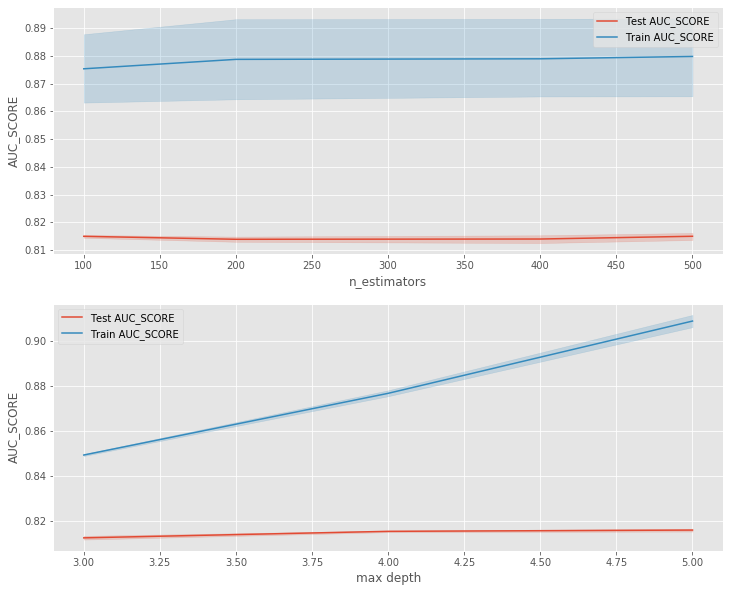

In [369]:
# plotting the roc_auc score w.r.t various parameters
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1) # subplots with 2 rows and 1 column
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()
# plotting the roc_auc score w.r.t various parameters
plt.subplot(2,1,2) # subplots with 2 rows and 1 column
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [370]:
model =clf.best_estimator_ #RandomForestClassifier(max_depth=5,n_estimators=400,min_samples_split=5,n_jobs=-1,oob_score=True,verbose=1)
model.fit(X_train_app,y_train_app)
y_pred = model.predict_proba(X_test_app) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_app,y_prob)))

AUC ROC Score on test data is 0.8058197145138521


In [371]:
y_pred = model.predict_proba(X_train_app)
y_prob = [prob[1] for prob in y_pred] # predicting probability of each class of occurence
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_train_app,y_prob)))

AUC ROC Score on test data is 0.8915671208751736


### Model with different parameters values

In [381]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=112, verbose=0,
                       warm_start=True)
model.fit(X_train_app,y_train_app) # fitting train data
y_pred = model.predict_proba(X_test_app)# predicting the test data
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_app,y_prob)))
# after the fitting the model with 4000 estimator we got our auc_roc score of 83.67 which is quite good and it's also not overfitting


AUC ROC Score on test data is 0.8312762109366957


In [383]:
y_pred = model.predict_proba(X_train_app) # model with 4000 estimator and max_depth of 5
y_prob = [prob[1] for prob in y_pred] # predicting probability of each class of occurence
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_train_app,y_prob))) # train data roc_auc score

AUC ROC Score on test data is 0.8819954816520582


1. We have used Random Forest and apply gridsearchcv with various parameter tuning but the result wasn't much exciting.
2. I have also trained the model with 4000 estimators also as you can see in above model.
3. But it overfitted, it's not highly overfitting.
4. Then we thought doing some feature selection as there can be some features which is not necessary i.e not very predictive or corrrelated with response variable.
5. So we thought of doing l1 regularizations as they will decrease each not so useful features weights to zero.

In [384]:
from sklearn.externals import joblib
joblib.dump(model,"rf_app.pkl") # # saving model as a pickle file
model = joblib.load("rf_app.pkl")
print(classification_report(y_test_app,model.predict(X_test_app)))

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      9822
           1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



### Lasso Regression for features selection

In [154]:
%%time

# gridsearch and randomized search are tow common techniques used for hyperparameter tuning.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

from sklearn.linear_model import Lasso
param = {"alpha":[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]}
model = Lasso()
clf = GridSearchCV(model,param_grid=param,cv=5,return_train_score=True,n_jobs=-1,scoring='roc_auc')
clf.fit(X_train_app,y_train_app)

Wall time: 29 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

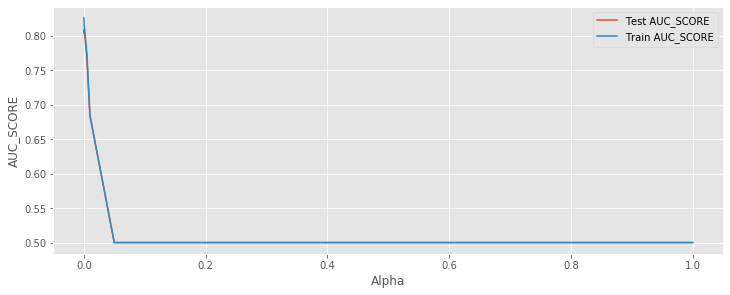

In [155]:
# plotting the roc_auc score w.r.t various parameters
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("Alpha")
plt.ylabel("AUC_SCORE")
plt.legend()

#### As we can see from above plot there is a quick fall, now we are going to zoom and find best alpha between 0 and 0.0005

In [157]:
%%time

# gridsearch and randomized search are tow common techniques used for hyperparameter tuning.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

from sklearn.linear_model import Lasso
param = {"alpha":[0.0001,0.0002,0.0025,0.0003,0.0035,0.0040,0.0045,0.0005,0.005]}
model = Lasso()
clf = GridSearchCV(model,param_grid=param,cv=3,return_train_score=True,n_jobs=-1,scoring='roc_auc')
clf.fit(X_train_app,y_train_app)

Wall time: 15.7 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0002, 0.0025, 0.0003, 0.0035,
                                   0.004, 0.0045, 0.0005, 0.005]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

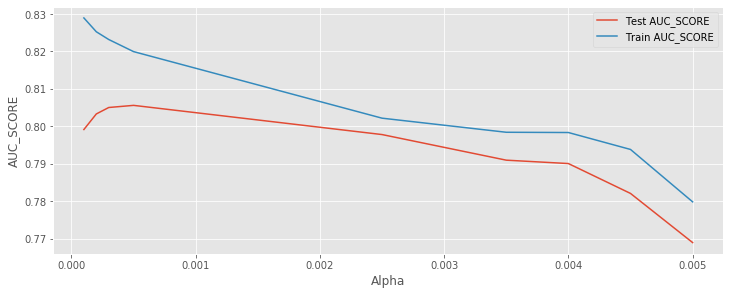

In [158]:
# plotting the roc_auc score w.r.t various parameters
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("Alpha")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

1. Now it's clearly visible how alpha value is behaving, it almost linear decrease 
2. So as alpha increases our roc_auc score also dereases but at initial alpha points we have overfitting problem so we have to chose alpha it the middle way.

### Using lasso for feature selection at alpha = 0.0025

In [159]:
lasso = Lasso(alpha=0.0025) # fitting the best alpha value
lasso.fit(X_train_app,y_train_app) 

Lasso(alpha=0.0025, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [160]:
new_col = list(X_train_app.columns[abs(lasso.coef_)>0]) # selecting features having |weights| greater than zero.
# new _col variable having selected features
X_train = X_train_app[new_col] #dataset containing those features which has weights greater than zero
X_test = X_test_app[new_col] # #dataset containing those features which has weights greater than zero

In [161]:
%%time

# for more info about random forest goto https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# there are many other parameters 
#RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
#, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
#bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


model = RandomForestClassifier(random_state=115,n_jobs=-1,warm_start=True)
param = {"n_estimators":[100,200,400,500]
         ,"max_depth":[3,4,5],"min_samples_split":[2,5,10,30]}
clf = GridSearchCV(model,param_grid=param,scoring="roc_auc",n_jobs=-1,return_train_score=True,verbose=1) # for hyperparameter tuning
clf.fit(X_train,y_train_app)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.6min finished


Wall time: 1min 38s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=115,
                                              verbose=0, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={

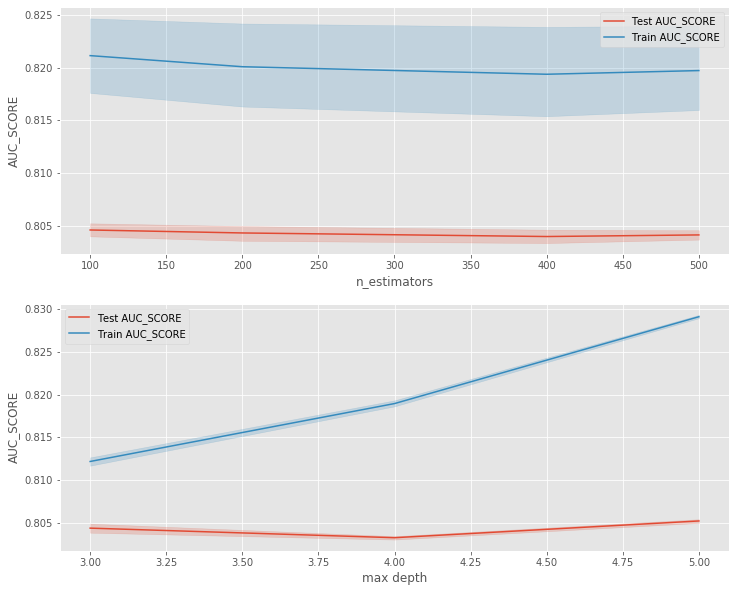

In [162]:
# plotting the roc_auc score w.r.t various parameters
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()
# plotting the roc_auc score w.r.t various parameters
plt.subplot(2,1,2)
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [163]:
model = clf.best_estimator_ # using best model according to gridsearchcv results
model.fit(X_train,y_train_app)
y_pred = model.predict_proba(X_test)
y_prob = [prob[1] for prob in y_pred] # predicting probability of each class of occurence
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_app,y_prob)))

AUC ROC Score on test data is 0.8164782567911064


In [166]:
y_pred = model.predict_proba(X_train) # model with 4000 estimator and max_depth of 5
y_prob = [prob[1] for prob in y_pred] # predicting probability of each class of occurence
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_app,y_prob))) # train data roc_auc score

AUC ROC Score on train data is 0.8100827274646003


1. As you can see that there is no overfitting in this model when we use feature selection techniques using lasso.
2. We got test auc_roc value as 81.64 and train roc_auc values as 81.00
3. We can see that our model has performed very well.

In [299]:
joblib.dump(model,"rf_app_fs.pkl")# saved the feature selection technique model.

### XGBoost

In [224]:
from xgboost import XGBClassifier
# https://xgboost.readthedocs.io/en/latest/parameter.html

In [229]:
%%time
model = XGBClassifier(n_jobs=-1,seed = 112) # 
param_dist = {"max_depth":[3,4,5],"n_estimators":[100,200,400,500],"gamma":[0,5,10]} # 
clf = GridSearchCV(model,param_grid = param_dist,return_train_score=True,scoring='roc_auc',verbose=1,n_jobs=-1) # hyperparameter tuning
clf.fit(X_train_app,y_train_app) 

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 80.6min finished


Wall time: 1h 20min 57s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=112, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [0, 5, 10], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 400, 500]},
             pre_dispatch='2*n

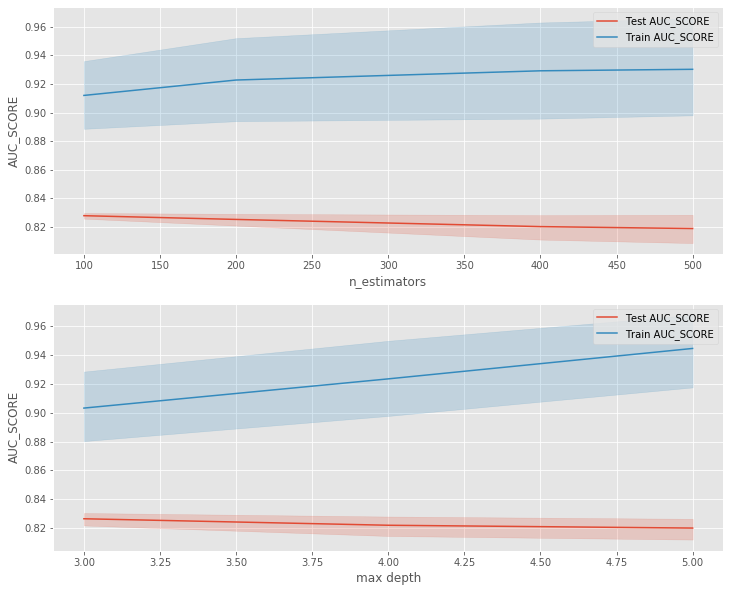

In [230]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [378]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.8, colsample_bytree=0.8, gamma=5,
              learning_rate=0.0001, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.9, scale_pos_weight=1, seed=112,
              silent=None, subsample=0.9, verbosity=1) # using best model according to gridsearchcv results
model.fit(X_train_app,y_train_app)
y_pred = model.predict_proba(X_test_app) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred] # 
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_app,y_prob)))

AUC ROC Score on test data is 0.8247253356944625


In [374]:
y_pred = model.predict_proba(X_train_app) # model with 4000 estimator and max_depth of 5
y_prob = [prob[1] for prob in y_pred] # predicting probability of each class of occurence
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_app,y_prob))) # train data roc_auc score

AUC ROC Score on train data is 0.8309301815289685


In [297]:
#joblib.dump(model,"xgb_app.pkl") # saving model as a pickle file
model = joblib.load("xgb_app.pkl")
print(classification_report(y_test_app,model.predict(X_test_app)))

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      9822
           1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



### Random Forrest on Churning data

In [173]:
%%time

# for more info about random forest goto https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# there are many other parameters 
#RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
#, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
#bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


model_churn = RandomForestClassifier(random_state=112,n_jobs=-1,warm_start=True)
param = {"n_estimators":[100,200,400,500]
         ,"max_depth":[3,4,5],"min_samples_split":[2,5,10,30]}
clf_churn = GridSearchCV(model_churn,param_grid=param,scoring="roc_auc",n_jobs=-1,return_train_score=True,verbose=1)
clf_churn.fit(X_train_churn,y_train_churn)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.2min finished


Wall time: 4min 14s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=112,
                                              verbose=0, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={

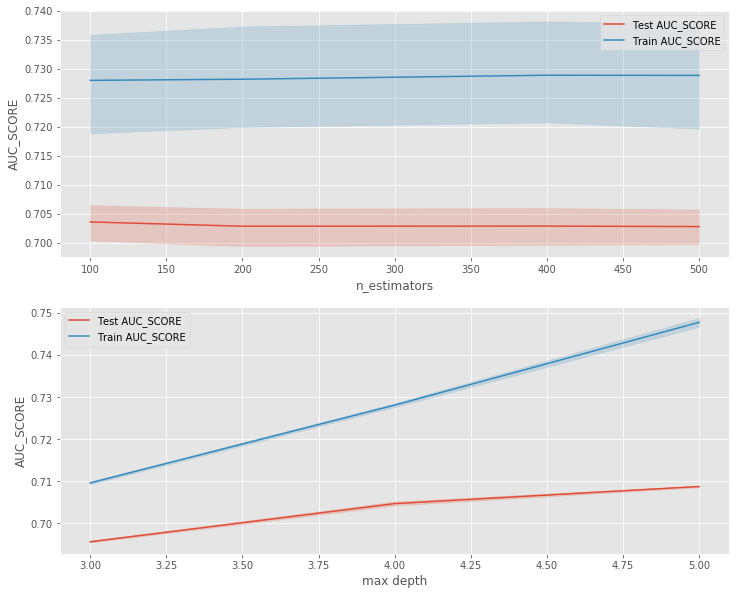

In [174]:
# plotting the test and train score on various paramters values.
# to see whether our model is generalized or not.i.e there should be no overfitting.
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf_churn.cv_results_['param_n_estimators'],y=clf_churn.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf_churn.cv_results_['param_n_estimators'],y=clf_churn.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf_churn.cv_results_['param_max_depth'],y=clf_churn.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf_churn.cv_results_['param_max_depth'],y=clf_churn.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [405]:
model_churn = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score = True, random_state=112, verbose=0,
                       warm_start=True)
model_churn.fit(X_train_churn,y_train_churn) # fitting churn data
y_pred = model_churn.predict_proba(X_test_churn) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_churn,y_prob))) # results on test data.

AUC ROC Score on test data is 0.6959557692680927


In [403]:
y_pred = model_churn.predict_proba(X_train_churn) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_churn,y_prob))) # result on train data

AUC ROC Score on train data is 0.7196533477892674


1. From above we can see that churning data not ooverfitting where our test score is 0.72 and train score 0.74.

In [406]:
joblib.dump(model_churn,"rf_churn.pkl") # saving model as a pickle file
model = joblib.load("rf_churn.pkl")
print(classification_report(y_test_churn,model.predict(X_test_churn)))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9266
           1       0.00      0.00      0.00       734

    accuracy                           0.93     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.86      0.93      0.89     10000



In [183]:
%%time

# gridsearch and randomized search are tow common techniques used for hyperparameter tuning.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

from sklearn.linear_model import Lasso
param = {"alpha":[0.0001,0.0002,0.0025,0.0003,0.0035,0.0040,0.0045,0.0005,0.005]}
model = Lasso()
clf = GridSearchCV(model,param_grid=param,cv=3,return_train_score=True,n_jobs=-1,scoring='roc_auc')
clf.fit(X_train_churn,y_train_churn)

Wall time: 1min 24s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0002, 0.0025, 0.0003, 0.0035,
                                   0.004, 0.0045, 0.0005, 0.005]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

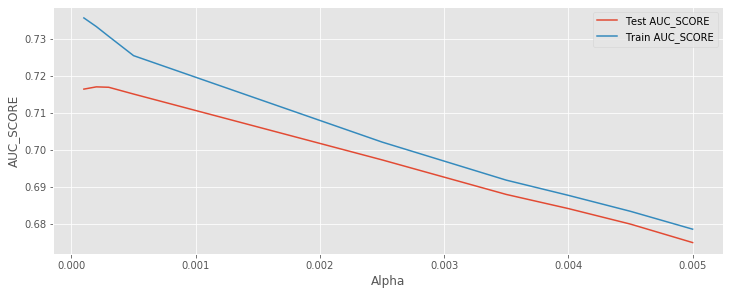

In [184]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_alpha'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("Alpha")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [185]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_app,y_train_app)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [186]:
new_col = list(X_train_app.columns[abs(lasso.coef_)>0]) # selecting features having |weights| greater than zero.
# new _col variable having selected features
X_train = X_train_app[new_col] 
X_test = X_test_app[new_col]

In [188]:
%%time

# for more info about random forest goto https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# there are many other parameters 
#RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
#, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
#bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


model = RandomForestClassifier(random_state=115,n_jobs=-1,warm_start=True)
param = {"n_estimators":[100,200,400,500]
         ,"max_depth":[3,4,5],"min_samples_split":[2,5,10,30]}
clf = GridSearchCV(model,param_grid=param,scoring="roc_auc",n_jobs=-1,return_train_score=True,verbose=1)
clf.fit(X_train,y_train_churn)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.9min finished


Wall time: 2min 54s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=115,
                                              verbose=0, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={

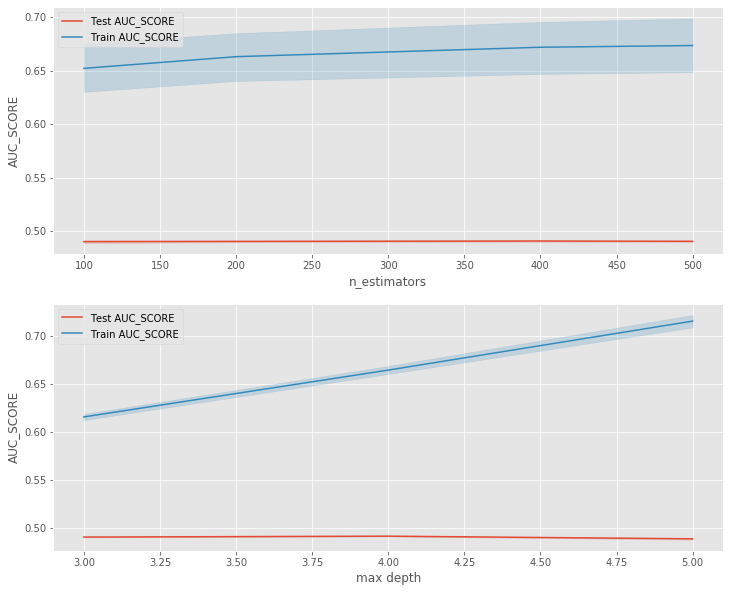

In [189]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [190]:
model = clf.best_estimator_ # using best model according to gridsearchcv results
model.fit(X_train,y_train_app) # predicting probability of each class of occurence
y_pred = model.predict_proba(X_test)
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_app,y_prob)))

AUC ROC Score on test data is 0.5938651822668213


In [191]:
y_pred = model.predict_proba(X_train) # model with 4000 estimator and max_depth of 5
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_app,y_prob))) # train data roc_auc score

AUC ROC Score on train data is 0.5405742761892014


### XGBoost

In [245]:
%%time
model = XGBClassifier(n_jobs=-1,seed = 112)
param_dist = {"max_depth":[3,4,5],"n_estimators":[100,200,400,500],"gamma":[0,5,10]}
clf = GridSearchCV(model,param_grid = param_dist,return_train_score=True,scoring='roc_auc',verbose=1,n_jobs=-1,cv = 2)
clf.fit(X_train_churn,y_train_churn)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 24.9min finished


Wall time: 25min 30s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=112, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [0, 5, 10], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 400, 500]},
             pre_dispatch='2*n_jobs

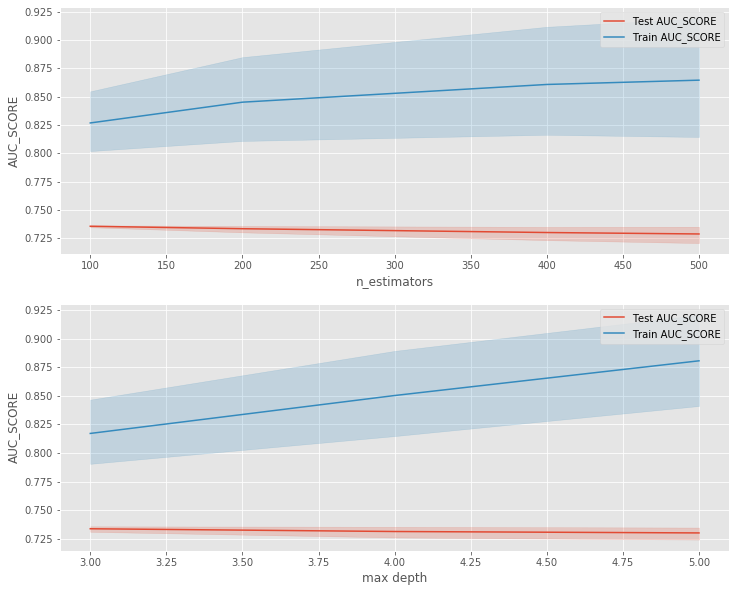

In [246]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [394]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1.0, colsample_bytree=0.8, gamma=5,
              learning_rate=0.0001, max_delta_step=0, max_depth=4,
              min_child_weight=15, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=112,
              reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=0.9, seed=112,
              silent=None, subsample=0.9, verbosity=1) # using best model according to gridsearchcv results
model.fit(X_train_churn,y_train_churn)
y_pred = model.predict_proba(X_test_churn)
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_churn,y_prob)))

AUC ROC Score on test data is 0.6315795316268612


In [392]:
y_pred = model.predict_proba(X_train_churn)  # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_churn,y_prob))) # train data roc_auc score

AUC ROC Score on train data is 0.7273356433733711


In [295]:
#joblib.dump(model,"xgb_churn.pkl") # # saving model as a pickle file
model = joblib.load("xgb_churn.pkl")
print(classification_report(y_test_churn,model.predict(X_test_churn)))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9266
           1       0.86      0.01      0.02       734

    accuracy                           0.93     10000
   macro avg       0.89      0.50      0.49     10000
weighted avg       0.92      0.93      0.89     10000



### Random Forrest on Upselling data

In [193]:
%%time
model_up = RandomForestClassifier(random_state=112,n_jobs=-1,warm_start=True)
param = {"n_estimators":[100,200,400,500]
         ,"max_depth":[3,4,5],"min_samples_split":[5,10,30]}
clf_up = GridSearchCV(model_up,param_grid=param,scoring="roc_auc",n_jobs=-1,return_train_score=True,verbose=1)
clf_up.fit(X_train_up,y_train_up)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.2min finished


Wall time: 3min 20s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=112,
                                              verbose=0, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={

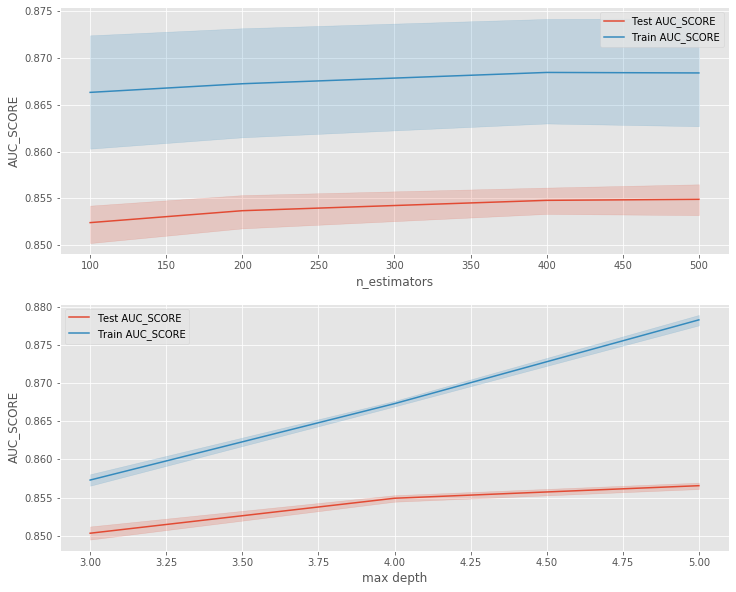

In [194]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf_up.cv_results_['param_n_estimators'],y=clf_up.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf_up.cv_results_['param_n_estimators'],y=clf_up.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf_up.cv_results_['param_max_depth'],y=clf_up.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf_up.cv_results_['param_max_depth'],y=clf_up.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [197]:
clf_up.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=112, verbose=0,
                       warm_start=True)

In [416]:
model_up = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=4000,
                       n_jobs=-1, oob_score=True, random_state=112, verbose=0,
                       warm_start=True)
model_up.fit(X_train_up,y_train_up) # predicting probability of each class of occurence
y_pred = model_up.predict_proba(X_test_up)
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_up,y_prob)))

AUC ROC Score on test data is 0.8414605743598408


In [417]:
y_pred = model_up.predict_proba(X_train_up) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_up,y_prob)))

AUC ROC Score on train data is 0.8706436077531073


In [418]:
# saving the model
joblib.dump(model_up,"rf_upsell.pkl")# saving model as a pickle file

['rf_upsell.pkl']

In [294]:
model = joblib.load("rf_upsell.pkl")
print(classification_report(y_test_up,model.predict(X_test_up)))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9264
           1       0.00      0.00      0.00       736

    accuracy                           0.93     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.86      0.93      0.89     10000



### XGBoost

In [272]:
%%time
model = XGBClassifier(n_jobs=-1,seed = 112)
param_dist = {"max_depth":[3,4,5],"n_estimators":[100,200,400,500],"gamma":[5,10]}
clf = GridSearchCV(model,param_grid = param_dist,return_train_score=True,scoring='roc_auc',verbose=1,n_jobs=-1,cv = 2)
clf.fit(X_train_up,y_train_up)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 23.4min finished


Wall time: 23min 58s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=112, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [5, 10], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 400, 500]},
             pre_dispatch='2*n_jobs', 

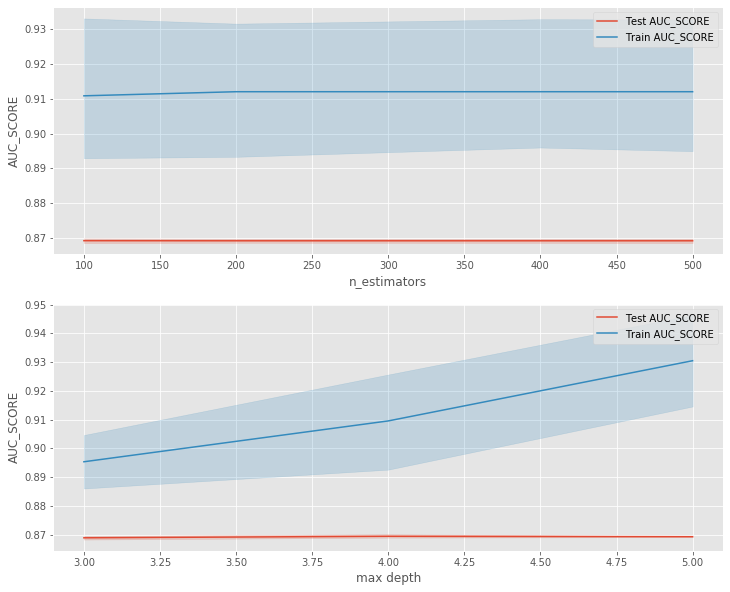

In [273]:
plt.style.use("ggplot")
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_n_estimators'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("n_estimators")
plt.ylabel("AUC_SCORE")
plt.legend()

plt.subplot(2,1,2)
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_test_score'],label = "Test AUC_SCORE")
sns.lineplot(x = clf.cv_results_['param_max_depth'],y=clf.cv_results_['mean_train_score'],label = "Train AUC_SCORE")
plt.xlabel("max depth")
plt.ylabel("AUC_SCORE")
plt.legend()
plt.show()

In [412]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.9, colsample_bytree=0.9, gamma=5,
              learning_rate=0.0001, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=0.8, scale_pos_weight=1, seed=112,
              silent=None, subsample=0.9, verbosity=1) # using best model according to gridsearchcv results
model.fit(X_train_up,y_train_up)
y_pred = model.predict_proba(X_test_up) # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on test data is {}".format(roc_auc_score(y_test_up,y_prob)))

AUC ROC Score on test data is 0.8492794542455133


In [413]:
y_pred = model.predict_proba(X_train_up)  # predicting probability of each class of occurence
y_prob = [prob[1] for prob in y_pred]
print("AUC ROC Score on train data is {}".format(roc_auc_score(y_train_up,y_prob))) # train data roc_auc score

AUC ROC Score on train data is 0.8678791106544894


In [414]:
joblib.dump(model,"xgb_upsell.pkl") # saving model as a pickle file
print(classification_report(y_train_up,model.predict(X_train_up))) # classification report

              precision    recall  f1-score   support

          -1       0.96      0.99      0.97     37054
           1       0.82      0.45      0.58      2946

    accuracy                           0.95     40000
   macro avg       0.89      0.72      0.78     40000
weighted avg       0.95      0.95      0.95     40000



1. From above results we can conclude that this model is not overfitting and able to predict or address upselling situation.
2. From above results of appetency,churning and upselling we can say that machine learning model after some feature engineering was unable to predict the churning data.
3. But perform quite good in appetency and upselling data.
4. The average AUC score will be less because of churn data which is <b>0.70</b>,but for appetency with auc score of <b>0.84</b> and upsell with auc score of<b>0.85</b> we have average auc score of <b>79.5</b>.

### Appetency Data

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

Using TensorFlow backend.


In [80]:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [119]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=293, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    return model
 
# create model
model = KerasClassifier(build_fn=create_model, verbose=2,epochs = 5)
model.fit(X_train_app,y_train_app[0])


Epoch 1/5
 - 7s - loss: 0.0935 - accuracy: 0.9784
Epoch 2/5
 - 7s - loss: 0.0806 - accuracy: 0.9822
Epoch 3/5
 - 7s - loss: 0.0785 - accuracy: 0.9822
Epoch 4/5
 - 7s - loss: 0.0776 - accuracy: 0.9822
Epoch 5/5
 - 7s - loss: 0.0771 - accuracy: 0.9822


In [120]:
res = model.predict(X_test_app)

In [156]:
from sklearn.metrics import classification_report
print("appetency model ",roc_auc_score(y_test_app,res)) # roc_auc score
print(classification_report(y_test_app,res))

appetency model  0.5
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      9822
           1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



### Saving the last data i.e feature engineering,min-max scaling etc is done.


In [ ]:
np.savez("App_processed",x = X_train_app,y = y_train_app,x1 = X_test_app,y1 = y_test_app)
np.savez("Churn_processed",x = X_train_churn,y = y_train_churn,x1 = X_test_churn,y1 = y_test_churn)
np.savez("Upsell_processed",x = X_train_up,y = y_train_up,x1 = X_test_up,y1 = y_test_up)

### Conclusion

In [292]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Data","AUC score","Average AUC score"]
x.add_row(["Xgboost with tuning","Appetency",0.826," "])
x.add_row(["Xgboost with tuning","Churn",0.698," "])
x.add_row(["Xgboost with tuning","Upsell",0.839,0.787])
x.add_row(["Random Forest with tuning","Appetency",0.841," "])
x.add_row(["Random Forest with tuning","Churn",0.701," "])
x.add_row(["Random Forest with tuning","Upsell",0.845,0.795])
print(x)

+---------------------------+-----------+-----------+-------------------+
|           Model           |    Data   | AUC score | Average AUC score |
+---------------------------+-----------+-----------+-------------------+
|    Xgboost with tuning    | Appetency |   0.826   |                   |
|    Xgboost with tuning    |   Churn   |   0.698   |                   |
|    Xgboost with tuning    |   Upsell  |   0.839   |       0.787       |
| Random Forest with tuning | Appetency |   0.841   |                   |
| Random Forest with tuning |   Churn   |   0.701   |                   |
| Random Forest with tuning |   Upsell  |   0.845   |       0.795       |
+---------------------------+-----------+-----------+-------------------+
